In [ ]:
# Install dependencies
!pip install -U sentence-transformers transformers scikit-learn

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/drive/MyDrive/tayyab/italian_crime_news.csv')
texts = df['text'].tolist()
labels = df['word2vec_tag'].tolist()
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [ ]:
# 3. Model Initialization
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
import torch

In [ ]:
# a) paraphrase-multilingual-MiniLM-L12-v2
model_a = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
# b) dbmdz/bert-base-italian-cased
tokenizer_b = AutoTokenizer.from_pretrained('dbmdz/bert-base-italian-cased')
model_b = AutoModel.from_pretrained('dbmdz/bert-base-italian-cased')
# c) intfloat/multilingual-e5-large-instruct
tokenizer_c = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large-instruct')
model_c = AutoModel.from_pretrained('intfloat/multilingual-e5-large-instruct')


In [ ]:
# 4. Embedding Generation
def get_transformer_embeddings(texts, tokenizer, model):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden = outputs.last_hidden_state
    # Mean pooling
    embeddings = last_hidden.mean(dim=1).cpu().numpy()
    return embeddings

In [ ]:
emb_a_train = model_a.encode(X_train, convert_to_numpy=True, show_progress_bar=True)
emb_a_test  = model_a.encode(X_test,  convert_to_numpy=True, show_progress_bar=True)


Batches:   0%|          | 0/260 [00:00<?, ?it/s]

Batches:   0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
def evaluate_embeddings(train_emb, test_emb, y_train, y_test):
    clf = SVC(kernel='linear', probability=True)
    clf.fit(train_emb, y_train)
    preds = clf.predict(test_emb)
    acc = accuracy_score(y_test, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, preds, average='weighted')
    return acc, prec, rec, f1


In [ ]:
results = []
for name, tr_emb, te_emb in [
    ('MiniLM', emb_a_train, emb_a_test)

]:
    acc, prec, rec, f1 = evaluate_embeddings(tr_emb, te_emb, y_train, y_test)
    results.append({'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1})


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
results_df = pd.DataFrame(results)

# 6. Comparison Grid Enrichment
# Append parameter counts and dims
param_info = {
    'MiniLM': {'#Params': model_a.get_sentence_embedding_dimension(), 'Dim': model_a.get_sentence_embedding_dimension(), 'Langs': 'Multilingual', 'Features': 'Lightweight, fast'}
}

for row in results:
    info = param_info[row['Model']]
    row.update(info)

full_grid = pd.DataFrame(results)
print(full_grid)

    Model  Accuracy  Precision    Recall        F1  #Params  Dim  \
0  MiniLM  0.709957   0.683532  0.709957  0.676885      384  384   

          Langs           Features  
0  Multilingual  Lightweight, fast  


In [ ]:
# 1. Install dependencies (run once)
!pip install -U sentence-transformers transformers scikit-learn imbalanced-learn xgboost

# 2. Mount Google Drive and set workspace
from google.colab import drive
import os
drive.mount('/content/drive')
# Persistent embedding cache on Drive\ nEMB_DIR = '/content/drive/MyDrive/tayyab/embeddings'
os.makedirs(EMB_DIR, exist_ok=True)

# 3. Imports
import pandas as pd
import numpy as np
torch
import gc
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter
from xgboost import XGBClassifier

# 4. Load and split data
df = pd.read_csv('/content/drive/MyDrive/tayyab/italian_crime_news.csv')
texts = df['text'].tolist()
labels = df['word2vec_tag'].tolist()
del df
gc.collect()
# Encode string labels to integers\ n
le = LabelEncoder()
y_all = le.fit_transform(labels)
# Stratified split on encoded labels
X_train, X_test, y_train, y_test = train_test_split(
    texts, y_all, test_size=0.2, stratify=y_all, random_state=42
)
del texts, labels, y_all
gc.collect()

# 5. Embedding caching/function
def get_embeddings(name, data):
    path = os.path.join(EMB_DIR, f'{name}.npy')
    if os.path.exists(path):
        print(f"Loading cached embeddings for {name}")
        return np.load(path)
    print(f"Computing embeddings for {name}")
    model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
    emb = model.encode(
        data,
        batch_size=32,
        convert_to_numpy=True,
        show_progress_bar=True,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        num_workers=4
    )
    np.save(path, emb)
    return emb

emb_train = get_embeddings('train', X_train)
emb_test  = get_embeddings('test', X_test)

del X_train, X_test
gc.collect()

# 6. Dimensionality reduction
scaler = StandardScaler()
train_scaled = scaler.fit_transform(emb_train)
test_scaled  = scaler.transform(emb_test)
pca = PCA(n_components=100, random_state=42)
emb_train_pca = pca.fit_transform(train_scaled)
emb_test_pca  = pca.transform(test_scaled)
del emb_train, emb_test, train_scaled, test_scaled
gc.collect()

# 7. Imbalance setup for Gradient Boosting
class_counts = Counter(y_train)
min_count = min(class_counts.values())
sk = min(5, min_count - 1) if min_count > 1 else 1

def maybe_smote(name, clf):
    if name == 'Gradient Boosting' and min_count > 1:
        sm = SMOTE(random_state=42, k_neighbors=sk)
        return ImbPipeline([('smote', sm), ('clf', clf)])
    return clf

# 8. Define classifiers (added XGBoost with multiclass settings)
num_classes = len(le.classes_)
classifiers = {
    'Linear SVM':        SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=500, n_jobs=-1, class_weight='balanced', random_state=42),
    'Extra Trees':       ExtraTreesClassifier(n_estimators=50, max_depth=20, n_jobs=-1, class_weight='balanced', random_state=42),
    'Random Forest':     RandomForestClassifier(n_estimators=50, max_depth=20, n_jobs=-1, class_weight='balanced_subsample', random_state=42),
    'XGBoost':           XGBClassifier(
                           objective='multi:softprob',
                           num_class=num_classes,
                           n_estimators=50,
                           max_depth=5,
                           use_label_encoder=False,
                           eval_metric='mlogloss',
                           random_state=42
                       ),
     'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, max_depth=5, random_state=42)
}

# 9. Evaluation function
def evaluate(clf, X_tr, y_tr, X_te, y_te):
    clf.fit(X_tr, y_tr)
    preds = clf.predict(X_te)
    acc = accuracy_score(y_te, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_te, preds, average='weighted', zero_division=0
    )
    return acc, prec, rec, f1

# 10. Run and report per classifier
results = []
for name, clf_base in classifiers.items():
    print(f"--- Evaluating: {name} ---")
    clf = maybe_smote(name, clf_base)
    acc, prec, rec, f1 = evaluate(clf, emb_train_pca, y_train, emb_test_pca, y_test)
    row = {'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-score': f1}
    results.append(row)
    print(pd.DataFrame([row]))

# 11. Final results and save
import pandas as pd
final_df = pd.DataFrame(results)
print("\n=== All Classifier Results ===")
print(final_df)
final_df.to_csv('/content/drive/MyDrive/tayyab/classifier_results_optimized.csv', index=False)
print("Saved results.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading cached embeddings for train
Loading cached embeddings for test
--- Evaluating: Linear SVM ---
        Model  Accuracy  Precision    Recall  F1-score
0  Linear SVM  0.554113   0.665628  0.554113  0.590369
--- Evaluating: Logistic Regression ---
                 Model  Accuracy  Precision    Recall  F1-score
0  Logistic Regression  0.497835   0.676208  0.497835  0.547163
--- Evaluating: Extra Trees ---
         Model  Accuracy  Precision    Recall  F1-score
0  Extra Trees  0.604618   0.555412  0.604618  0.475431
--- Evaluating: Random Forest ---
           Model  Accuracy  Precision    Recall  F1-score
0  Random Forest  0.617124   0.514317  0.617124  0.508596
--- Evaluating: XGBoost ---


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:59:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


     Model  Accuracy  Precision   Recall  F1-score
0  XGBoost   0.67292   0.637178  0.67292  0.628655
--- Evaluating: Gradient Boosting ---
               Model  Accuracy  Precision    Recall  F1-score
0  Gradient Boosting  0.597403   0.635555  0.597403   0.61236

=== All Classifier Results ===
                 Model  Accuracy  Precision    Recall  F1-score
0           Linear SVM  0.554113   0.665628  0.554113  0.590369
1  Logistic Regression  0.497835   0.676208  0.497835  0.547163
2          Extra Trees  0.604618   0.555412  0.604618  0.475431
3        Random Forest  0.617124   0.514317  0.617124  0.508596
4              XGBoost  0.672920   0.637178  0.672920  0.628655
5    Gradient Boosting  0.597403   0.635555  0.597403  0.612360
Saved results.


In [ ]:
#version 2


# 1. Install dependencies (run once)
!pip install -U sentence-transformers transformers scikit-learn imbalanced-learn xgboost

# 2. Mount Google Drive and set workspace
from google.colab import drive
import os
drive.mount('/content/drive')

EMB_DIR = '/content/drive/MyDrive/tayyab/embeddings'
os.makedirs(EMB_DIR, exist_ok=True)

# 3. Imports
import pandas as pd
import numpy as np
import torch
import gc
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter
from xgboost import XGBClassifier

# 4. Load and split data
df = pd.read_csv('/content/drive/MyDrive/tayyab/italian_crime_news.csv')
texts = df['text'].tolist()
labels = df['word2vec_tag'].tolist()
del df
gc.collect()

# Encode string labels to integers
le = LabelEncoder()
y_all = le.fit_transform(labels)

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    texts, y_all, test_size=0.2, stratify=y_all, random_state=42
)
del texts, labels, y_all
gc.collect()

# 5. Embedding caching/function
def get_embeddings(name, data):
    path = os.path.join(EMB_DIR, f'{name}.npy')
    if os.path.exists(path):
        print(f"Loading cached embeddings for {name}")
        return np.load(path)
    print(f"Computing embeddings for {name}")
    model = SentenceTransformer('all-mpnet-base-v2')  # Stronger encoder
    emb = model.encode(
        data,
        batch_size=32,
        convert_to_numpy=True,
        show_progress_bar=True,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        num_workers=4
    )
    np.save(path, emb)
    return emb

emb_train = get_embeddings('train', X_train)
emb_test  = get_embeddings('test', X_test)
del X_train, X_test
gc.collect()

# 6. Dimensionality reduction
scaler = StandardScaler()
train_scaled = scaler.fit_transform(emb_train)
test_scaled  = scaler.transform(emb_test)
pca = PCA(n_components=100, random_state=42)
emb_train_pca = pca.fit_transform(train_scaled)
emb_test_pca  = pca.transform(test_scaled)
del emb_train, emb_test, train_scaled, test_scaled
gc.collect()

# 7. Sampling methods
class_counts = Counter(y_train)
min_count = min(class_counts.values())
sk = min(5, min_count - 1) if min_count > 1 else 1

samplers = {
    'None': None,
    'SMOTE': SMOTE(random_state=42, k_neighbors=sk),
    'ADASYN': ADASYN(random_state=42),
    'RandomOver': RandomOverSampler(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42)
}

# 8. Define classifiers
num_classes = len(le.classes_)
base_classifiers = {
    'Linear SVM':        SVC(kernel='linear', probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=500, n_jobs=-1, random_state=42),
    'Extra Trees':       ExtraTreesClassifier(n_estimators=50, max_depth=20, n_jobs=-1, random_state=42),
    'Random Forest':     RandomForestClassifier(n_estimators=50, max_depth=20, n_jobs=-1, random_state=42),
    'XGBoost':           XGBClassifier(
                           objective='multi:softprob',
                           num_class=num_classes,
                           n_estimators=50,
                           max_depth=5,
                           use_label_encoder=False,
                           eval_metric='mlogloss',
                           random_state=42
                       )
}

# 9. Evaluation function
def evaluate(clf, X_tr, y_tr, X_te, y_te):
    clf.fit(X_tr, y_tr)
    preds = clf.predict(X_te)
    acc = accuracy_score(y_te, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_te, preds, average='weighted', zero_division=0
    )
    return acc, prec, rec, f1

# 10. Run with all samplers
results = []

for sampler_name, sampler in samplers.items():
    print(f"\n### Sampling: {sampler_name} ###")
    for clf_name, clf in base_classifiers.items():
        print(f"--- Evaluating: {clf_name} ---")
        if sampler:
            pipeline = ImbPipeline([('sampling', sampler), ('clf', clf)])
        else:
            pipeline = clf
        acc, prec, rec, f1 = evaluate(pipeline, emb_train_pca, y_train, emb_test_pca, y_test)
        row = {
            'Sampler': sampler_name,
            'Model': clf_name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-score': f1
        }
        results.append(row)
        print(pd.DataFrame([row]))

# 11. Ensemble VotingClassifier with soft voting (using top 3)
print("\n=== Ensemble Evaluation (Voting Classifier) ===")
voting_clf = VotingClassifier(
    estimators=[
        ('lr', base_classifiers['Logistic Regression']),
        ('xgb', base_classifiers['XGBoost']),
        ('rf', base_classifiers['Random Forest'])
    ],
    voting='soft'
)

# Wrap ensemble in sampler if needed (try with best sampler here)
best_sampler = SMOTE(random_state=42, k_neighbors=sk)  # or use the one that performed best
voting_pipeline = ImbPipeline([('sampling', best_sampler), ('clf', voting_clf)])
acc, prec, rec, f1 = evaluate(voting_pipeline, emb_train_pca, y_train, emb_test_pca, y_test)
row = {
    'Sampler': 'SMOTE',
    'Model': 'VotingClassifier (LR+XGB+RF)',
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-score': f1
}
results.append(row)
print(pd.DataFrame([row]))

# 12. Save final results
final_df = pd.DataFrame(results)
print("\n=== All Classifier Results ===")
print(final_df)
final_df.to_csv('/content/drive/MyDrive/tayyab/classifier_results_with_sampling.csv', index=False)
print("Saved results.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading cached embeddings for train
Loading cached embeddings for test

### Sampling: None ###
--- Evaluating: Linear SVM ---
  Sampler       Model  Accuracy  Precision   Recall  F1-score
0    None  Linear SVM   0.68254    0.66383  0.68254  0.659171
--- Evaluating: Logistic Regression ---
  Sampler                Model  Accuracy  Precision    Recall  F1-score
0    None  Logistic Regression  0.683021   0.655241  0.683021  0.661213
--- Evaluating: Extra Trees ---
  Sampler        Model  Accuracy  Precision    Recall  F1-score
0    None  Extra Trees  0.623377   0.554807  0.623377  0.515807
--- Evaluating: Random Forest ---
  Sampler          Model  Accuracy  Precision    Recall  F1-score
0    None  Random Forest  0.644541   0.585652  0.644541  0.566021
--- Evaluating: XGBoost ---


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:44:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Sampler    Model  Accuracy  Precision   Recall  F1-score
0    None  XGBoost   0.67292   0.637178  0.67292  0.628655

### Sampling: SMOTE ###
--- Evaluating: Linear SVM ---


In [ ]:
# 1. Install dependencies (unchanged)
!pip install -U sentence-transformers transformers scikit-learn xgboost spacy
!python -m spacy download it_core_news_sm

# 2. Mount Google Drive (unchanged)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 3. Setup paths (unchanged)
import os
EMB_DIR = '/content/drive/MyDrive/tayyab/embeddings_fe'
os.makedirs(EMB_DIR, exist_ok=True)

# 4. Enhanced imports
import re
import pandas as pd
import numpy as np
import torch
import gc
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from xgboost import XGBClassifier
from collections import Counter

# 5. Optimized data loading
df = pd.read_csv('/content/drive/MyDrive/tayyab/italian_crime_news.csv')
df = df.dropna(subset=['text']).astype({'text': 'string'})  # Use pandas string type
texts = df['text'].tolist()
labels = df['word2vec_tag'].tolist()
del df
gc.collect()

# 6. Encode labels & split (unchanged)
le = LabelEncoder()
y_all = le.fit_transform(labels)
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts, y_all, test_size=0.2, stratify=y_all, random_state=42
)
del texts, labels, y_all
gc.collect()

# 7. Enhanced feature extraction
nlp = spacy.load('it_core_news_sm', exclude=["tagger", "parser", "attribute_ruler", "lemmatizer"])
crime_keywords = {'omicidio','furto','arresto','rapina','droga','corruzione'}
crime_pattern = re.compile(r'\b(?:' + '|'.join(map(re.escape, crime_keywords)) + r')\b', flags=re.IGNORECASE)

def extract_features(texts):
    feats = []
    for doc in nlp.pipe(texts, batch_size=512):  # Increased batch size for Spacy
        t = doc.text
        num_chars = len(t)
        num_words = len(doc)
        alpha_tokens = [tok for tok in doc if tok.is_alpha]
        avg_wlen = np.mean([len(tok.text) for tok in alpha_tokens]) if alpha_tokens else 0
        num_sents = t.count('.') + t.count('!') + t.count('?')
        num_up = sum(1 for tok in doc if tok.is_upper and tok.is_alpha)
        num_stop = sum(1 for tok in doc if tok.is_stop)
        has_kw = int(bool(crime_pattern.search(t)))  # Regex-based keyword check

        feats.append([
            num_chars, num_words, avg_wlen, num_sents,
            num_up, num_stop, len(doc.ents), has_kw
        ])
    return np.array(feats, dtype=np.float32)  # Reduced precision

# 8. Optimized feature caching and scaling
train_feat_path = os.path.join(EMB_DIR, 'train_feats.npy')
test_feat_path  = os.path.join(EMB_DIR, 'test_feats.npy')

if not (os.path.exists(train_feat_path) and os.path.exists(test_feat_path)):
    print("Computing engineered features")
    X_train_feats = extract_features(X_train_texts)
    X_test_feats  = extract_features(X_test_texts)
    np.save(train_feat_path, X_train_feats)
    np.save(test_feat_path,  X_test_feats)
else:
    print("Loading cached engineered features")
    X_train_feats = np.load(train_feat_path)
    X_test_feats  = np.load(test_feat_path)

# Memory-efficient scaling
scaler_feats = StandardScaler()
X_train_feats = scaler_feats.fit_transform(X_train_feats).astype(np.float32)
X_test_feats  = scaler_feats.transform(X_test_feats).astype(np.float32)

# 9. Optimized embeddings with model reuse
sentence_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

def get_embeddings(name, texts):
    cache_path = os.path.join(EMB_DIR, f'{name}_fe.npy')
    if os.path.exists(cache_path):
        print(f"Loading cached embeddings for '{name}'")
        return np.load(cache_path)
    print(f"Computing embeddings for '{name}'")
    emb = sentence_model.encode(
        texts,
        batch_size=128,  # Increased batch size
        convert_to_numpy=True,
        show_progress_bar=True,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        normalize_embeddings=True  # Ensure L2 normalization
    ).astype(np.float32)  # Reduced precision
    np.save(cache_path, emb)
    return emb

emb_train = get_embeddings('train', X_train_texts)
emb_test  = get_embeddings('test',  X_test_texts)

del X_train_texts, X_test_texts
gc.collect()

# 10. Optimized PCA with memory-efficient types
scaler_emb = StandardScaler()
train_sc = scaler_emb.fit_transform(emb_train).astype(np.float32)
test_sc  = scaler_emb.transform(emb_test).astype(np.float32)

pca = PCA(n_components=0.95, random_state=42)  # Keep 95% variance
emb_train_pca = pca.fit_transform(train_sc)
emb_test_pca  = pca.transform(test_sc)

del emb_train, emb_test, train_sc, test_sc
gc.collect()

# 11. Combine features (unchanged)
X_train_final = np.hstack([emb_train_pca, X_train_feats])
X_test_final  = np.hstack([emb_test_pca,  X_test_feats])

# 12. CV folds (unchanged)
class_counts = Counter(y_train)
min_count = min(class_counts.values())
n_splits = min(5, min_count) if min_count > 1 else 2
print(f"Using StratifiedKFold with n_splits={n_splits} (smallest class size = {min_count})")
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 13. Optimized hyperparameter grids
search_space = {
    'Logistic Regression': (
        LogisticRegression(solver='saga', max_iter=1000, random_state=42),
        {'C': [0.1, 1, 10], 'penalty': ['l2', 'l1']},
        GridSearchCV
    ),
    'Linear SVM': (
        LinearSVC(dual='auto', random_state=42),
        {'C': [0.1, 1, 10]},
        GridSearchCV
    ),
    'Random Forest': (
        RandomForestClassifier(random_state=42),
        {'n_estimators': [200], 'max_depth': [20, None], 'max_features': ['sqrt']},
        RandomizedSearchCV,
        5  # n_iter
    ),
    'XGBoost': (
        XGBClassifier(
            objective='multi:softmax',
            num_class=len(le.classes_),
            random_state=42
        ),
        {'n_estimators': [200], 'max_depth': [5], 'learning_rate': [0.1]},
        GridSearchCV
    )
}

# 14. Optimized model tuning
results = []
for name, (model, params, searcher, *args) in search_space.items():
    print(f"\n🔍 Tuning {name}")
    if searcher == RandomizedSearchCV:
        search = searcher(model, params, n_iter=args[0], cv=cv,
                         scoring='f1_weighted', n_jobs=-1, verbose=1)
    else:
        search = searcher(model, params, cv=cv, scoring='f1_weighted',
                         n_jobs=-1, verbose=1)

    search.fit(X_train_final, y_train)
    best = search.best_estimator_
    preds = best.predict(X_test_final)

    metrics = {
        'Model': name,
        'Best Params': search.best_params_,
        'Accuracy': accuracy_score(y_test, preds),
        **dict(zip(
            ['Precision', 'Recall', 'F1-score'],
            precision_recall_fscore_support(y_test, preds, average='weighted', zero_division=0)[:3]
        ))
    }
    results.append(metrics)
    print(pd.DataFrame([metrics]))

# 15. Save results (unchanged)
final_df = pd.DataFrame(results)
print("\n=== Tuned Results ===")
print(final_df)
final_df.to_csv('/content/drive/MyDrive/tayyab/classifier_results_tuned_optimized.csv', index=False)
print("Saved optimized results to Drive.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 35.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Mounted at /content/drive
Computing engineered features
Loading cached embeddings for 'train'
Loading cached embeddings for 'test'
Using StratifiedKFold with n_splits=2 (smallest class size = 2)

🔍 Tuning Logistic Regression
Fitting 2 folds for each of 6 candidates, totalling 12 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


                 Model                  Best Params  Accuracy  Precision  \
0  Logistic Regression  {'C': 0.1, 'penalty': 'l2'}  0.721928   0.696136   

     Recall  F1-score  
0  0.721928  0.704648  

🔍 Tuning Linear SVM
Fitting 2 folds for each of 3 candidates, totalling 6 fits
        Model Best Params  Accuracy  Precision    Recall  F1-score
0  Linear SVM    {'C': 1}  0.721928   0.686051  0.721928  0.689395

🔍 Tuning Random Forest
Fitting 2 folds for each of 2 candidates, totalling 4 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


           Model                                        Best Params  Accuracy  \
0  Random Forest  {'n_estimators': 200, 'max_features': 'sqrt', ...  0.691566   

   Precision    Recall  F1-score  
0   0.645276  0.691566  0.618274  

🔍 Tuning XGBoost
Fitting 2 folds for each of 1 candidates, totalling 2 fits
     Model                                        Best Params  Accuracy  \
0  XGBoost  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  0.729157   

   Precision    Recall  F1-score  
0    0.70539  0.729157  0.687351  

=== Tuned Results ===
                 Model                                        Best Params  \
0  Logistic Regression                        {'C': 0.1, 'penalty': 'l2'}   
1           Linear SVM                                           {'C': 1}   
2        Random Forest  {'n_estimators': 200, 'max_features': 'sqrt', ...   
3              XGBoost  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   

   Accuracy  Precision    Recall  F1-score  
0  0.721928   0

In [ ]:
#version 4.1 – Expanded Grid Search

# 1. Install dependencies (unchanged)
!pip install -U sentence-transformers transformers scikit-learn xgboost spacy
!python -m spacy download it_core_news_sm

# 2. Mount Google Drive (unchanged)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 3. Setup paths (unchanged)
import os
EMB_DIR = '/content/drive/MyDrive/tayyab/embeddings_fe'
os.makedirs(EMB_DIR, exist_ok=True)

# 4. Imports
import re
import pandas as pd
import numpy as np
import torch
import gc
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from xgboost import XGBClassifier
from collections import Counter

# 5. Load and clean data
df = pd.read_csv('/content/drive/MyDrive/tayyab/italian_crime_news.csv')
df = df.dropna(subset=['text'])
df['text'] = df['text'].astype(str)
texts = df['text'].tolist()
labels = df['word2vec_tag'].tolist()
del df
gc.collect()

# 6. Encode labels & train/test split
le = LabelEncoder()
y_all = le.fit_transform(labels)
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts, y_all, test_size=0.2, stratify=y_all, random_state=42
)
del texts, labels, y_all
gc.collect()

# 7. Feature extraction setup
nlp = spacy.load('it_core_news_sm', exclude=["tagger","parser","attribute_ruler","lemmatizer"])
crime_keywords = {'omicidio','furto','arresto','rapina','droga','corruzione'}
crime_pattern = re.compile(r'\b(?:' + '|'.join(map(re.escape, crime_keywords)) + r')\b', flags=re.IGNORECASE)

def extract_features(texts):
    feats = []
    for doc in nlp.pipe(texts, batch_size=512):
        t = doc.text
        num_chars = len(t)
        num_words = len(doc)
        alpha = [tok for tok in doc if tok.is_alpha]
        avg_wlen = np.mean([len(tok) for tok in alpha]) if alpha else 0
        num_sents = t.count('.') + t.count('!') + t.count('?')
        num_up = sum(1 for tok in doc if tok.is_upper and tok.is_alpha)
        num_stop = sum(1 for tok in doc if tok.is_stop)
        num_ents = len(doc.ents)
        has_kw = int(bool(crime_pattern.search(t)))
        feats.append([num_chars, num_words, avg_wlen, num_sents,
                      num_up, num_stop, num_ents, has_kw])
    return np.array(feats, dtype=np.float32)

# 8. Cache or compute engineered features
train_feat_path = os.path.join(EMB_DIR, 'train_feats.npy')
test_feat_path  = os.path.join(EMB_DIR, 'test_feats.npy')

if os.path.exists(train_feat_path) and os.path.exists(test_feat_path):
    print("Loading cached engineered features")
    X_train_feats = np.load(train_feat_path)
    X_test_feats  = np.load(test_feat_path)
else:
    print("Computing engineered features")
    X_train_feats = extract_features(X_train_texts)
    X_test_feats  = extract_features(X_test_texts)
    np.save(train_feat_path, X_train_feats)
    np.save(test_feat_path,  X_test_feats)

# scale features
scaler_feats = StandardScaler()
X_train_feats = scaler_feats.fit_transform(X_train_feats).astype(np.float32)
X_test_feats  = scaler_feats.transform(X_test_feats).astype(np.float32)

# 9. Embeddings with caching & normalization
sentence_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

def get_embeddings(name, texts):
    cache_path = os.path.join(EMB_DIR, f'{name}_fe.npy')
    if os.path.exists(cache_path):
        print(f"Loading cached embeddings for '{name}'")
        return np.load(cache_path)
    print(f"Computing embeddings for '{name}'")
    emb = sentence_model.encode(
        texts,
        batch_size=128,
        convert_to_numpy=True,
        show_progress_bar=True,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        normalize_embeddings=True
    ).astype(np.float32)
    np.save(cache_path, emb)
    return emb

emb_train = get_embeddings('train', X_train_texts)
emb_test  = get_embeddings('test',  X_test_texts)

del X_train_texts, X_test_texts
gc.collect()

# 10. PCA on embeddings
scaler_emb = StandardScaler()
train_sc = scaler_emb.fit_transform(emb_train).astype(np.float32)
test_sc  = scaler_emb.transform(emb_test).astype(np.float32)

pca = PCA(n_components=0.95, random_state=42)  # keep 95% variance
emb_train_pca = pca.fit_transform(train_sc)
emb_test_pca  = pca.transform(test_sc)

del emb_train, emb_test, train_sc, test_sc
gc.collect()

# 11. Combine engineered features + embeddings
X_train_final = np.hstack([emb_train_pca, X_train_feats])
X_test_final  = np.hstack([emb_test_pca,  X_test_feats])

# 12. Determine number of CV folds
class_counts = Counter(y_train)
min_count = min(class_counts.values())
n_splits = min(5, min_count) if min_count > 1 else 2
print(f"Using StratifiedKFold(n_splits={n_splits})  smallest class size={min_count}")
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 13. Hyperparameter grids with more options
search_space = {
    'Logistic Regression': (
        LogisticRegression(solver='saga', max_iter=2000, class_weight='balanced', random_state=42),
        {
            'C': [0.001, 0.01, 0.1, 1, 10],
            'penalty': ['l2','l1'],
            'solver': ['saga','liblinear']
        }
    ),
    'Linear SVM': (
        LinearSVC(dual='auto', class_weight='balanced', max_iter=10000, random_state=42),
        {
            'C': [0.01, 0.1, 1, 10],
            'loss': ['hinge','squared_hinge']
        }
    ),
    'Random Forest': (
        RandomForestClassifier(class_weight='balanced_subsample', random_state=42),
        {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'max_features': ['sqrt','log2', None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    ),
    'Extra Trees': (
        ExtraTreesClassifier(class_weight='balanced_subsample', random_state=42),
        {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'max_features': ['sqrt','log2', None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    ),
    'XGBoost': (
        XGBClassifier(
            objective='multi:softprob',
            num_class=len(le.classes_),
            use_label_encoder=False,
            eval_metric='mlogloss',
            scale_pos_weight=1.0,
            random_state=42
        ),
        {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'gamma': [0, 1, 5],
            'reg_alpha': [0, 0.1, 1],
            'reg_lambda': [0.5, 1, 2]
        }
    )
}

# 14. GridSearchCV + evaluation
results = []
for name, (model, params) in search_space.items():
    print(f"\n🔍 Tuning {name}")
    grid = GridSearchCV(
        estimator=model,
        param_grid=params,
        cv=cv,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train_final, y_train)
    best = grid.best_estimator_
    preds = best.predict(X_test_final)
    acc = accuracy_score(y_test, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, preds, average='weighted', zero_division=0
    )
    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1
    })
    print(pd.DataFrame([results[-1]]))

# 15. Save results
final_df = pd.DataFrame(results)
print("\n=== Final Tuned Results ===")
print(final_df)
final_df.to_csv('/content/drive/MyDrive/tayyab/classifier_results_tuned_weights.csv', index=False)
print("Saved optimized results with extended grid search to Drive.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loading cached embeddings for 'train'
Loading cached embeddings for 'test'
Using StratifiedKFold(n_splits=2)  smallest class size=2

🔍 Tuning Logistic Regression
Fitting 2 folds for each of 20 candidates, totalling 40 fits
                 Model                                        Best Params  \
0  Logistic Regression  {'C': 0.1, 'penalty': 'l1', 'solver': 'libline...   

   Accuracy  Precision    Recall  F1-score  
0  0.657349   0.718881  0.657349   0.67488  

🔍 Tuning Linear SVM
Fitting 2 folds for each of 8 candidates, totalling 16 fits
        Model                        Best Params  Accuracy  Precision  \
0  Linear SVM  {'C': 1, 'loss': 'squared_hinge'}   0.65253   0.729652   

    Recall  F1-score  
0  0.65253  0.675696  

🔍 Tuning Random Forest
Fitting 2 folds for each of 324 candidates, totalling 648 fits
           Model                                        Best Params  Accuracy  \
0  Random Forest  {'max_depth': 10, 'max_features': 'sqrt', 'min...  0.662651   

   Preci

In [ ]:
# ==============================================================================
# INSTALLATIONS (Run once per new Colab runtime)
# ==============================================================================
# !pip install -U sentence-transformers transformers spacy tensorflow keras --progress-bar off
# !python -m spacy download it_core_news_sm

# ==============================================================================
# MAIN SCRIPT
# ==============================================================================
import os
import gc
import re
import shutil
import time

import tensorflow as tf
import keras
# import keras_tuner as kt # REMOVED Keras Tuner
import numpy as np
import pandas as pd
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split # Removed StratifiedKFold for now
from sklearn.preprocessing import LabelEncoder, StandardScaler
from google.colab import drive

def initial_gpu_check():
    print(f"TensorFlow Version: {tf.__version__}")
    print(f"Keras Version: {keras.__version__}")

    gpus = tf.config.list_physical_devices('GPU')
    print(f"Physical GPUs available: {gpus}")

    if gpus:
        try:
            print("Attempting to set memory growth for GPUs...")
            for gpu_device in gpus:
                tf.config.experimental.set_memory_growth(gpu_device, True)
            print("GPU memory growth set successfully.")

            print("Performing a simple TensorFlow operation on GPU...")
            with tf.device('/GPU:0'): # Explicitly use the first GPU
                a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
                b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
                c = tf.matmul(a, b)
            print(f"Simple TF GPU matmul test successful. Result matrix:\n{c.numpy()}")
            print("Successfully initialized and tested GPU.")
            return True
        except RuntimeError as e:
            print(f"!!!!!!!! ERROR DURING GPU INITIALIZATION OR TEST: {e} !!!!!!!!")
            print(f"Colab environment issue. Disconnect/delete runtime, ensure GPU, rerun installs & script.")
            return False
    else:
        print(f"!!!!!!!! NO GPU DETECTED BY TENSORFLOW !!!!!!!!")
        print("Ensure 'GPU' is selected in 'Runtime' -> 'Change runtime type'.")
        return False

if not initial_gpu_check():
    raise SystemExit("GPU initialization failed. Stopping script.")

drive.mount('/content/drive', force_remount=True)

BASE_DIR = '/content/drive/MyDrive/tayyab'
EMB_DIR = os.path.join(BASE_DIR, 'embeddings_fe') # Versioning - Keeping this as features/embeddings themselves are not changing
RESULT_CSV = os.path.join(BASE_DIR, 'deep_classifier_results_manual_dl_v3.csv') # Versioning - New results file

os.makedirs(EMB_DIR, exist_ok=True)

if os.path.exists(RESULT_CSV):
    print(f"Removing existing results file: {RESULT_CSV}")
    os.remove(RESULT_CSV)


print("Loading and cleaning data...")
csv_path = os.path.join(BASE_DIR, 'italian_crime_news.csv')
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV file not found at: {csv_path}")
df = pd.read_csv(csv_path)
df.dropna(subset=['text'], inplace=True)
df['text'] = df['text'].astype(str)
texts_full = df['text'].tolist()
labels_full = df['word2vec_tag'].tolist()

del df; gc.collect()

print("Encoding labels...")
en = LabelEncoder()
y_encoded_full = en.fit_transform(labels_full)
num_classes = len(en.classes_)

X_train_texts, X_test_texts, y_train_np, y_test_np = train_test_split(
    texts_full, y_encoded_full, test_size=0.2, stratify=y_encoded_full, random_state=42
)
del texts_full, labels_full, y_encoded_full; gc.collect()


print("Setting up spaCy for feature extraction...")
components_to_exclude = ["parser", "tagger", "attribute_ruler", "lemmatizer"]
try:
    nlp = spacy.load('it_core_news_sm', exclude=components_to_exclude)
    print(f"spaCy pipeline loaded with components: {nlp.pipe_names}")
    if not (any(comp in nlp.pipe_names for comp in ['senter', 'sentencizer'])):
        print("Warning: No sentence boundary detector found. Adding 'sentencizer'.")
        nlp.add_pipe("sentencizer", first=True)
    if 'ner' not in nlp.pipe_names:
        print("Warning: NER component not found, but doc.ents is used. Consider adjusting excludes.")

except OSError:
    print("Downloading 'it_core_news_sm' spaCy model...")
    # This line is for Colab/Jupyter environments.
    # If running locally and spacy is not in a virtual env, you might need to adjust.
    import subprocess
    subprocess.run(['python', '-m', 'spacy', 'download', 'it_core_news_sm'])
    nlp = spacy.load('it_core_news_sm', exclude=components_to_exclude)
    print(f"spaCy pipeline loaded after download with components: {nlp.pipe_names}")
    if not (any(comp in nlp.pipe_names for comp in ['senter', 'sentencizer'])):
        print("Warning: No sentence boundary detector found. Adding 'sentencizer'.")
        nlp.add_pipe("sentencizer", first=True)


crime_kw = {'omicidio','furto','arresto','rapina','droga','corruzione'}
kw_pattern = re.compile(r"\b(?:" + "|".join(map(re.escape, crime_kw)) + r")\b", flags=re.IGNORECASE)

def extract_feats(input_texts):
    feats = []
    for doc in nlp.pipe(input_texts, batch_size=128):
        t = doc.text
        num_chars = len(t); num_words = len(doc)
        alpha = [tok for tok in doc if tok.is_alpha]
        avg_w = np.mean([len(tok.text) for tok in alpha]) if alpha else 0
        sents = sum(1 for _ in doc.sents)
        up = sum(1 for tok in doc if tok.is_upper and tok.is_alpha)
        stp = sum(1 for tok in doc if tok.is_stop)
        ents = len(doc.ents)
        has_kw = int(bool(kw_pattern.search(t)))
        feats.append([num_chars, num_words, avg_w, sents, up, stp, ents, has_kw])
    return np.array(feats, dtype=np.float32)

train_feats_fpath = os.path.join(EMB_DIR, 'train_feats.npy')
if os.path.exists(train_feats_fpath):
    print("Loading TRAIN engineered features from cache...")
    X_train_feats = np.load(train_feats_fpath)
else:
    print("Extracting TRAIN engineered features ..."); X_train_feats = extract_feats(X_train_texts)
    print("Saving TRAIN engineered features ..."); np.save(train_feats_fpath, X_train_feats)

test_feats_fpath = os.path.join(EMB_DIR, 'test_feats.npy')
if os.path.exists(test_feats_fpath):
    print("Loading TEST engineered features from cache...")
    X_test_feats = np.load(test_feats_fpath)
else:
    print("Extracting TEST engineered features ..."); X_test_feats = extract_feats(X_test_texts)
    print("Saving TEST engineered features ..."); np.save(test_feats_fpath, X_test_feats)


scaler_feats = StandardScaler()
X_train_feats = scaler_feats.fit_transform(X_train_feats)
X_test_feats  = scaler_feats.transform(X_test_feats)

print("Setting up SentenceTransformer model...")
try:
    sent_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
except Exception as e: print(f"Error loading SentenceTransformer model: {e}"); raise

def get_emb(name, input_texts_list, model_emb_dir):
    cache = os.path.join(model_emb_dir, f'{name}_emb_manual.npy')
    if os.path.exists(cache):
        print(f"Loading {name} embeddings from cache: {cache}"); return np.load(cache)

    print(f"Generating {name} embeddings...")
    emb_device = 'cuda' if tf.config.list_physical_devices('GPU') else 'cpu'
    print(f"Using device: {emb_device} for sentence embeddings.")

    embeddings = sent_model.encode(
        input_texts_list, batch_size=32, show_progress_bar=True,
        device=emb_device, normalize_embeddings=True
    )
    print(f"Saving {name} embeddings to cache: {cache}"); np.save(cache, embeddings)
    return embeddings

emb_train = get_emb('train', X_train_texts, EMB_DIR)
emb_test  = get_emb('test',  X_test_texts, EMB_DIR)


print("Releasing SentenceTransformer model and text lists from memory...")
del sent_model; del X_train_texts; del X_test_texts; gc.collect()

print("Combining features and embeddings...")
X_train_final = np.hstack([emb_train, X_train_feats]); del emb_train, X_train_feats; gc.collect()
X_test_final  = np.hstack([emb_test,  X_test_feats]);  del emb_test, X_test_feats;  gc.collect()

input_dim = X_train_final.shape[1]

print(f"Final X_train_final shape: {X_train_final.shape}, y_train_np shape: {y_train_np.shape}")
print(f"Input dimension for model: {input_dim}, Number of classes: {num_classes}")


def build_and_compile_model(params_dict, current_input_dim, current_num_classes):
    keras.backend.clear_session(); gc.collect()

    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(current_input_dim,)))

    # First hidden layer (always present if num_hidden_layers >= 1)
    model.add(keras.layers.Dense(units=params_dict.get('units_0', 32), activation='relu'))
    model.add(keras.layers.Dropout(rate=params_dict.get('dropout_0', 0.2)))

    if params_dict.get('num_hidden_layers', 1) >= 2: # Second hidden layer
        model.add(keras.layers.Dense(units=params_dict.get('units_1', 32), activation='relu'))
        model.add(keras.layers.Dropout(rate=params_dict.get('dropout_1', 0.2)))

    if params_dict.get('num_hidden_layers', 1) >= 3: # Third hidden layer
        model.add(keras.layers.Dense(units=params_dict.get('units_2', 16), activation='relu')) # Default units for 3rd layer
        model.add(keras.layers.Dropout(rate=params_dict.get('dropout_2', 0.1))) # Default dropout for 3rd layer

    model.add(keras.layers.Dense(current_num_classes, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=params_dict.get('learning_rate', 1e-4)),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model

# Updated model configurations: more complex models added
model_configurations = [
    # Original configurations (can be kept for baseline or commented out)
    {'name': 'model_1_small_1layer', 'units_0': 32, 'dropout_0': 0.2, 'num_hidden_layers': 1, 'learning_rate': 1e-4},
    {'name': 'model_2_medium_1layer', 'units_0': 64, 'dropout_0': 0.3, 'num_hidden_layers': 1, 'learning_rate': 1e-4},
    {'name': 'model_3_small_2layer', 'units_0': 32, 'dropout_0': 0.2, 'units_1': 32, 'dropout_1': 0.2, 'num_hidden_layers': 2, 'learning_rate': 1e-4},
    {'name': 'model_4_medium_2layer_high_lr', 'units_0': 64, 'dropout_0': 0.3, 'units_1': 32, 'dropout_1': 0.2, 'num_hidden_layers': 2, 'learning_rate': 1e-3},

    # New, more complex configurations
    {'name': 'model_5_large_1layer', 'units_0': 128, 'dropout_0': 0.3, 'num_hidden_layers': 1, 'learning_rate': 1e-4},
    {'name': 'model_6_medium_2layer_v2', 'units_0': 128, 'dropout_0': 0.3, 'units_1': 64, 'dropout_1': 0.2, 'num_hidden_layers': 2, 'learning_rate': 1e-4},
    {'name': 'model_7_small_3layer_taper', 'units_0': 64, 'dropout_0': 0.2, 'units_1': 32, 'dropout_1': 0.2, 'units_2': 16, 'dropout_2': 0.1, 'num_hidden_layers': 3, 'learning_rate': 1e-4},
    {'name': 'model_8_medium_3layer_taper', 'units_0': 128, 'dropout_0': 0.3, 'units_1': 64, 'dropout_1': 0.2, 'units_2': 32, 'dropout_2': 0.1, 'num_hidden_layers': 3, 'learning_rate': 1e-4},
    {'name': 'model_9_large_3layer_taper_high_lr', 'units_0': 256, 'dropout_0': 0.4, 'units_1': 128, 'dropout_1': 0.3, 'units_2': 64, 'dropout_2': 0.2, 'num_hidden_layers': 3, 'learning_rate': 5e-4}, # Even more complex
]

all_results = []
EPOCHS_PER_MODEL = 15 # Increased epochs
BATCH_SIZE_TRAIN = 32

for i, config in enumerate(model_configurations):
    print(f"\n--- Training Configuration: {config['name']} ({i+1}/{len(model_configurations)}) ---")

    print(f"Building model: {config['name']}")
    model = build_and_compile_model(config, input_dim, num_classes)
    model.summary()

    early_stop_cb = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True, verbose=1 # Increased patience slightly
    )

    history = None; training_successful = False
    try:
        print(f"Starting training for {config['name']}...")
        time.sleep(1)

        history = model.fit(
            X_train_final, y_train_np,
            epochs=EPOCHS_PER_MODEL,
            batch_size=BATCH_SIZE_TRAIN,
            validation_split=0.15,
            callbacks=[early_stop_cb],
            verbose=1
        )
        print(f"Training completed for {config['name']}.")
        training_successful = True

    except tf.errors.FailedPreconditionError as e_tf:
        print(f"!!!!!!!! TENSORFLOW FAILED PRECONDITION ERROR for {config['name']}: {e_tf} !!!!!!!!")
    except Exception as e_generic:
        print(f"!!!!!!!! GENERIC ERROR during training of {config['name']}: {e_generic} !!!!!!!!")
        import traceback; traceback.print_exc()

    if training_successful and history:
        print(f"Evaluating {config['name']} on test set...")
        test_loss, test_acc = model.evaluate(X_test_final, y_test_np, batch_size=BATCH_SIZE_TRAIN, verbose=0)
        print(f"Test Results for {config['name']} - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

        # Ensure history has the keys before accessing
        final_val_loss = history.history['val_loss'][-1] if history.history and 'val_loss' in history.history and history.history['val_loss'] else None
        final_val_accuracy = history.history['val_accuracy'][-1] if history.history and 'val_accuracy' in history.history and history.history['val_accuracy'] else None

        # If early stopping restored best weights, we might want the best val_loss/acc, not the last.
        # However, for simplicity and consistency with previous script, keeping last.
        # To get best: best_epoch_idx = np.argmin(history.history['val_loss'])
        # final_val_loss = history.history['val_loss'][best_epoch_idx]
        # final_val_accuracy = history.history['val_accuracy'][best_epoch_idx]


        current_result = {
            'model_name': config['name'], **config,
            'test_loss': test_loss, 'test_accuracy': test_acc,
            'final_val_loss': final_val_loss,
            'final_val_accuracy': final_val_accuracy,
            'epochs_run': len(history.history['loss']) # Actual epochs run if early stopped
        }
        all_results.append(current_result)
    else:
        print(f"Skipping evaluation for {config['name']} due to training failure or no history.")
        current_result = {
            'model_name': config['name'], **config,
            'test_loss': None, 'test_accuracy': None,
            'final_val_loss': None, 'final_val_accuracy': None,
            'epochs_run': 0
        }
        all_results.append(current_result) # Still log the config even if it failed

    del model; del history; gc.collect(); keras.backend.clear_session()
    print(f"Cleaned up after {config['name']}. Waiting a bit...")
    time.sleep(2)

if all_results:
    df_all_results = pd.DataFrame(all_results)
    print("\n--- All Model Results ---"); print(df_all_results)
    df_all_results.to_csv(RESULT_CSV, index=False)
    print(f"All results saved to {RESULT_CSV}")
else:
    print("No models were processed or produced results.")

print("Script finished.")

TensorFlow Version: 2.18.0
Keras Version: 3.8.0
Physical GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Attempting to set memory growth for GPUs...
GPU memory growth set successfully.
Performing a simple TensorFlow operation on GPU...
Simple TF GPU matmul test successful. Result matrix:
[[22. 28.]
 [49. 64.]]
Successfully initialized and tested GPU.
Mounted at /content/drive
Loading and cleaning data...
Encoding labels...
Setting up spaCy for feature extraction...
spaCy pipeline loaded with components: ['tok2vec', 'morphologizer', 'ner']
Loading TRAIN engineered features from cache...
Loading TEST engineered features from cache...
Setting up SentenceTransformer model...
Loading train embeddings from cache: /content/drive/MyDrive/tayyab/embeddings_fe/train_emb_manual.npy
Loading test embeddings from cache: /content/drive/MyDrive/tayyab/embeddings_fe/test_emb_manual.npy
Releasing SentenceTransformer model and text lists from memory...
Combining feature

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        12,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,005 (50.80 KB)

 Trainable params: 13,005 (50.80 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_1_small_1layer...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4419 - loss: 2.3573 - val_accuracy: 0.6337 - val_loss: 1.9496
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6400 - loss: 1.8173 - val_accuracy: 0.6418 - val_loss: 1.4804
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6358 - loss: 1.4526 - val_accuracy: 0.6498 - val_loss: 1.2636
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6588 - loss: 1.2592 - val_accuracy: 0.6594 - val_loss: 1.1715
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6708 - loss: 1.1813 - val_accuracy: 0.6627 - val_loss: 1.1289
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6695 - loss: 1.1690 - val_accuracy: 0.6731 - val_loss: 1.1021
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6877 - loss: 1.1089 - val_accuracy: 0.6779 - val_loss: 1.0836
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        25,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,997 (101.55 KB)

 Trainable params: 25,997 (101.55 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_2_medium_1layer...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.3504 - loss: 2.3968 - val_accuracy: 0.5831 - val_loss: 1.8151
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5983 - loss: 1.6698 - val_accuracy: 0.5984 - val_loss: 1.3339
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6230 - loss: 1.3133 - val_accuracy: 0.6337 - val_loss: 1.2055
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6606 - loss: 1.2025 - val_accuracy: 0.6562 - val_loss: 1.1488
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6764 - loss: 1.1509 - val_accuracy: 0.6659 - val_loss: 1.1125
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6912 - loss: 1.1061 - val_accuracy: 0.6747 - val_loss: 1.0864
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6897 - loss: 1.0744 - val_accuracy: 0.6771 - val_loss: 1.0651
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - ac

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        12,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,061 (54.93 KB)

 Trainable params: 14,061 (54.93 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_3_small_2layer...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.3403 - loss: 2.4432 - val_accuracy: 0.5871 - val_loss: 1.8911
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5970 - loss: 1.7213 - val_accuracy: 0.5968 - val_loss: 1.3428
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6101 - loss: 1.3825 - val_accuracy: 0.6345 - val_loss: 1.2135
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6461 - loss: 1.2586 - val_accuracy: 0.6627 - val_loss: 1.1543
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6654 - loss: 1.1970 - val_accuracy: 0.6699 - val_loss: 1.1211
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6669 - loss: 1.1585 - val_accuracy: 0.6779 - val_loss: 1.0990
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6858 - loss: 1.1211 - val_accuracy: 0.6803 - val_loss: 1.0818
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        25,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,661 (108.05 KB)

 Trainable params: 27,661 (108.05 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_4_medium_2layer_high_lr...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5505 - loss: 1.6413 - val_accuracy: 0.6803 - val_loss: 1.0475
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6853 - loss: 1.0582 - val_accuracy: 0.6908 - val_loss: 0.9847
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6950 - loss: 0.9797 - val_accuracy: 0.7036 - val_loss: 0.9229
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7084 - loss: 0.9174 - val_accuracy: 0.7124 - val_loss: 0.8848
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7125 - loss: 0.8820 - val_accuracy: 0.7173 - val_loss: 0.8689
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7228 - loss: 0.8337 - val_accuracy: 0.7181 - val_loss: 0.8513
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7274 - loss: 0.8319 - val_accuracy: 0.7141 - val_loss: 0.8399
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/s

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,981 (203.05 KB)

 Trainable params: 51,981 (203.05 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_5_large_1layer...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4281 - loss: 2.2918 - val_accuracy: 0.5904 - val_loss: 1.5241
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6181 - loss: 1.3945 - val_accuracy: 0.6450 - val_loss: 1.2080
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6770 - loss: 1.1672 - val_accuracy: 0.6635 - val_loss: 1.1279
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6798 - loss: 1.1265 - val_accuracy: 0.6747 - val_loss: 1.0895
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6870 - loss: 1.0678 - val_accuracy: 0.6819 - val_loss: 1.0649
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6871 - loss: 1.0572 - val_accuracy: 0.6819 - val_loss: 1.0446
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6808 - loss: 1.0495 - val_accuracy: 0.6835 - val_loss: 1.0279
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,405 (232.05 KB)

 Trainable params: 59,405 (232.05 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_6_medium_2layer_v2...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.3496 - loss: 2.3442 - val_accuracy: 0.6040 - val_loss: 1.4248
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6319 - loss: 1.3549 - val_accuracy: 0.6522 - val_loss: 1.1847
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6694 - loss: 1.2171 - val_accuracy: 0.6610 - val_loss: 1.1237
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6854 - loss: 1.1205 - val_accuracy: 0.6683 - val_loss: 1.0878
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6800 - loss: 1.1086 - val_accuracy: 0.6739 - val_loss: 1.0596
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6885 - loss: 1.0489 - val_accuracy: 0.6795 - val_loss: 1.0401
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6834 - loss: 1.0433 - val_accuracy: 0.6827 - val_loss: 1.0251
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        25,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,981 (109.30 KB)

 Trainable params: 27,981 (109.30 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_7_small_3layer_taper...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.2706 - loss: 2.4142 - val_accuracy: 0.5936 - val_loss: 1.7124
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5860 - loss: 1.6152 - val_accuracy: 0.6008 - val_loss: 1.3065
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6152 - loss: 1.3656 - val_accuracy: 0.6482 - val_loss: 1.2120
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6480 - loss: 1.2983 - val_accuracy: 0.6675 - val_loss: 1.1549
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6803 - loss: 1.1871 - val_accuracy: 0.6819 - val_loss: 1.1154
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6701 - loss: 1.1691 - val_accuracy: 0.6771 - val_loss: 1.0884
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6729 - loss: 1.1549 - val_accuracy: 0.6851 - val_loss: 1.0688
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,069 (238.55 KB)

 Trainable params: 61,069 (238.55 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_8_medium_3layer_taper...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.4182 - loss: 2.3251 - val_accuracy: 0.5839 - val_loss: 1.3519
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6184 - loss: 1.3211 - val_accuracy: 0.6442 - val_loss: 1.1741
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6592 - loss: 1.1961 - val_accuracy: 0.6643 - val_loss: 1.1130
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6683 - loss: 1.1660 - val_accuracy: 0.6779 - val_loss: 1.0873
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6760 - loss: 1.1226 - val_accuracy: 0.6803 - val_loss: 1.0643
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6980 - loss: 1.0507 - val_accuracy: 0.6803 - val_loss: 1.0513
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6876 - loss: 1.0568 - val_accuracy: 0.6835 - val_loss: 1.0401
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       100,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,605 (557.05 KB)

 Trainable params: 142,605 (557.05 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_9_large_3layer_taper_high_lr...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5170 - loss: 1.7791 - val_accuracy: 0.6795 - val_loss: 1.0716
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6813 - loss: 1.0781 - val_accuracy: 0.6948 - val_loss: 0.9971
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7016 - loss: 0.9965 - val_accuracy: 0.7012 - val_loss: 0.9462
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7056 - loss: 0.9290 - val_accuracy: 0.7141 - val_loss: 0.8939
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7183 - loss: 0.8780 - val_accuracy: 0.7149 - val_loss: 0.8795
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7222 - loss: 0.8348 - val_accuracy: 0.7060 - val_loss: 0.8676
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7336 - loss: 0.8125 - val_accuracy: 0.7116 - val_loss: 0.8593
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [ ]:
# ==============================================================================
# INSTALLATIONS (Run once per new Colab runtime)
# ==============================================================================
# !pip install -U sentence-transformers transformers spacy tensorflow keras torch tqdm --progress-bar off
# !python -m spacy download it_core_news_sm

# ==============================================================================
# MAIN SCRIPT
# ==============================================================================
import os
import gc
import re
import shutil
import time

import tensorflow as tf
import keras
# import keras_tuner as kt # REMOVED Keras Tuner
import numpy as np
import pandas as pd
import spacy
# from sentence_transformers import SentenceTransformer # REMOVED
from transformers import AutoTokenizer, AutoModel # ADDED
import torch # ADDED
from tqdm.auto import tqdm # ADDED for progress bar

from sklearn.model_selection import train_test_split # Removed StratifiedKFold for now
from sklearn.preprocessing import LabelEncoder, StandardScaler
from google.colab import drive

def initial_gpu_check():
    print(f"TensorFlow Version: {tf.__version__}")
    print(f"Keras Version: {keras.__version__}")
    print(f"PyTorch Version: {torch.__version__}") # ADDED PyTorch version check

    gpus_tf = tf.config.list_physical_devices('GPU')
    print(f"Physical GPUs available (TensorFlow): {gpus_tf}")

    if torch.cuda.is_available():
        print(f"PyTorch CUDA available. Device: {torch.cuda.get_device_name(0)}")
    else:
        print("PyTorch CUDA not available.")

    if gpus_tf:
        try:
            print("Attempting to set memory growth for GPUs (TensorFlow)...")
            for gpu_device in gpus_tf:
                tf.config.experimental.set_memory_growth(gpu_device, True)
            print("GPU memory growth set successfully (TensorFlow).")

            print("Performing a simple TensorFlow operation on GPU...")
            with tf.device('/GPU:0'): # Explicitly use the first GPU
                a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
                b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
                c = tf.matmul(a, b)
            print(f"Simple TF GPU matmul test successful. Result matrix:\n{c.numpy()}")
            print("Successfully initialized and tested GPU for TensorFlow.")
            return True
        except RuntimeError as e:
            print(f"!!!!!!!! ERROR DURING TENSORFLOW GPU INITIALIZATION OR TEST: {e} !!!!!!!!")
            print(f"Colab environment issue. Disconnect/delete runtime, ensure GPU, rerun installs & script.")
            return False
    else:
        print(f"!!!!!!!! NO GPU DETECTED BY TENSORFLOW !!!!!!!!")
        print("Ensure 'GPU' is selected in 'Runtime' -> 'Change runtime type'.")
        return False

if not initial_gpu_check():
    raise SystemExit("GPU initialization failed. Stopping script.")

drive.mount('/content/drive', force_remount=True)

BASE_DIR = '/content/drive/MyDrive/tayyab'
EMB_DIR = os.path.join(BASE_DIR, 'embeddings_fe_e5_large_instruct') # Versioning - New dir for new embeddings
RESULT_CSV = os.path.join(BASE_DIR, 'deep_classifier_results_manual_dl_v3_e5_large_instruct.csv') # Versioning - New results file

os.makedirs(EMB_DIR, exist_ok=True)

if os.path.exists(RESULT_CSV):
    print(f"Removing existing results file: {RESULT_CSV}")
    os.remove(RESULT_CSV)


print("Loading and cleaning data...")
csv_path = os.path.join(BASE_DIR, 'italian_crime_news.csv')
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV file not found at: {csv_path}")
df = pd.read_csv(csv_path)
df.dropna(subset=['text'], inplace=True)
df['text'] = df['text'].astype(str)
texts_full = df['text'].tolist()
labels_full = df['word2vec_tag'].tolist()

del df; gc.collect()

print("Encoding labels...")
en = LabelEncoder()
y_encoded_full = en.fit_transform(labels_full)
num_classes = len(en.classes_)

X_train_texts, X_test_texts, y_train_np, y_test_np = train_test_split(
    texts_full, y_encoded_full, test_size=0.2, stratify=y_encoded_full, random_state=42
)
del texts_full, labels_full, y_encoded_full; gc.collect()


print("Setting up spaCy for feature extraction...")
components_to_exclude = ["parser", "tagger", "attribute_ruler", "lemmatizer"]
try:
    nlp = spacy.load('it_core_news_sm', exclude=components_to_exclude)
    print(f"spaCy pipeline loaded with components: {nlp.pipe_names}")
    if not (any(comp in nlp.pipe_names for comp in ['senter', 'sentencizer'])):
        print("Warning: No sentence boundary detector found. Adding 'sentencizer'.")
        nlp.add_pipe("sentencizer", first=True)
    if 'ner' not in nlp.pipe_names:
        print("Warning: NER component not found, but doc.ents is used. Consider adjusting excludes.")

except OSError:
    print("Downloading 'it_core_news_sm' spaCy model...")
    import subprocess
    subprocess.run(['python', '-m', 'spacy', 'download', 'it_core_news_sm'])
    nlp = spacy.load('it_core_news_sm', exclude=components_to_exclude)
    print(f"spaCy pipeline loaded after download with components: {nlp.pipe_names}")
    if not (any(comp in nlp.pipe_names for comp in ['senter', 'sentencizer'])):
        print("Warning: No sentence boundary detector found. Adding 'sentencizer'.")
        nlp.add_pipe("sentencizer", first=True)


crime_kw = {'omicidio','furto','arresto','rapina','droga','corruzione'}
kw_pattern = re.compile(r"\b(?:" + "|".join(map(re.escape, crime_kw)) + r")\b", flags=re.IGNORECASE)

def extract_feats(input_texts):
    feats = []
    for doc in nlp.pipe(input_texts, batch_size=128):
        t = doc.text
        num_chars = len(t); num_words = len(doc)
        alpha = [tok for tok in doc if tok.is_alpha]
        avg_w = np.mean([len(tok.text) for tok in alpha]) if alpha else 0
        sents = sum(1 for _ in doc.sents)
        up = sum(1 for tok in doc if tok.is_upper and tok.is_alpha)
        stp = sum(1 for tok in doc if tok.is_stop)
        ents = len(doc.ents)
        has_kw = int(bool(kw_pattern.search(t)))
        feats.append([num_chars, num_words, avg_w, sents, up, stp, ents, has_kw])
    return np.array(feats, dtype=np.float32)

train_feats_fpath = os.path.join(EMB_DIR, 'train_feats.npy') # EMB_DIR changed, so path is new
if os.path.exists(train_feats_fpath):
    print("Loading TRAIN engineered features from cache...")
    X_train_feats = np.load(train_feats_fpath)
else:
    print("Extracting TRAIN engineered features ..."); X_train_feats = extract_feats(X_train_texts)
    print("Saving TRAIN engineered features ..."); np.save(train_feats_fpath, X_train_feats)

test_feats_fpath = os.path.join(EMB_DIR, 'test_feats.npy') # EMB_DIR changed, so path is new
if os.path.exists(test_feats_fpath):
    print("Loading TEST engineered features from cache...")
    X_test_feats = np.load(test_feats_fpath)
else:
    print("Extracting TEST engineered features ..."); X_test_feats = extract_feats(X_test_texts)
    print("Saving TEST engineered features ..."); np.save(test_feats_fpath, X_test_feats)


scaler_feats = StandardScaler()
X_train_feats = scaler_feats.fit_transform(X_train_feats)
X_test_feats  = scaler_feats.transform(X_test_feats)

print("Setting up Hugging Face BERT model (dbmdz/bert-base-italian-cased)...")
try:
    tokenizer_b = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large-instruct')
    model_b = AutoModel.from_pretrained('intfloat/multilingual-e5-large-instruct')
    #tokenizer_b = AutoTokenizer.from_pretrained('dbmdz/bert-base-italian-cased')
    #model_b = AutoModel.from_pretrained('dbmdz/bert-base-italian-cased')
except Exception as e:
    print(f"Error loading Hugging Face model: {e}"); raise

def get_emb(name, input_texts_list, model_emb_dir, tokenizer, model, batch_size=32, max_length=512):
    """
    Generates embeddings for a list of texts using a Hugging Face transformer model.
    Performs mean pooling of last hidden states and L2 normalizes the embeddings.
    """
    # Use a different cache filename to reflect the new model
    cache_filename = f'{name}_emb_bert_italian_cased.npy'
    cache_path = os.path.join(model_emb_dir, cache_filename)

    if os.path.exists(cache_path):
        print(f"Loading {name} embeddings from cache: {cache_path}")
        return np.load(cache_path)

    print(f"Generating {name} embeddings with {model.config._name_or_path}...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device} for {model.config._name_or_path} embeddings.")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    all_embeddings_list = []
    num_texts = len(input_texts_list)

    for i in tqdm(range(0, num_texts, batch_size), desc=f"Encoding {name} batches"):
        batch_texts = input_texts_list[i : i + batch_size]
        if not batch_texts:
            continue

        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"  # Return PyTorch tensors
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():  # Disable gradient calculations
            outputs = model(**inputs)
            last_hidden_states = outputs.last_hidden_state
            attention_mask = inputs['attention_mask']

            # Mean Pooling:
            # Expand attention_mask to [batch_size, seq_len, 1] to broadcast with last_hidden_states
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_states.size()).float()
            # Sum embeddings where attention_mask is 1
            sum_embeddings = torch.sum(last_hidden_states * input_mask_expanded, 1)
            # Sum of mask elements (number of non-padding tokens per sentence)
            sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9) # Avoid division by zero
            mean_pooled_embeddings = sum_embeddings / sum_mask

        all_embeddings_list.append(mean_pooled_embeddings.cpu().numpy())

    embeddings_np = np.vstack(all_embeddings_list)

    # L2 Normalization (similar to normalize_embeddings=True in SentenceTransformer)
    norm = np.linalg.norm(embeddings_np, axis=1, keepdims=True)
    embeddings_np = embeddings_np / np.where(norm == 0, 1e-9, norm) # Avoid division by zero if norm is 0

    print(f"Saving {name} embeddings to cache: {cache_path}")
    np.save(cache_path, embeddings_np)
    return embeddings_np


emb_train = get_emb('train', X_train_texts, EMB_DIR, tokenizer_b, model_b, batch_size=32)
emb_test  = get_emb('test',  X_test_texts,  EMB_DIR, tokenizer_b, model_b, batch_size=32)


print("Releasing Hugging Face model and text lists from memory...")
del model_b; del tokenizer_b; # DEL Hugging Face model and tokenizer
del X_train_texts; del X_test_texts; gc.collect(); torch.cuda.empty_cache() # Empty PyTorch cache

print("Combining features and embeddings...")
X_train_final = np.hstack([emb_train, X_train_feats]); del emb_train, X_train_feats; gc.collect()
X_test_final  = np.hstack([emb_test,  X_test_feats]);  del emb_test, X_test_feats;  gc.collect()

input_dim = X_train_final.shape[1]

print(f"Final X_train_final shape: {X_train_final.shape}, y_train_np shape: {y_train_np.shape}")
print(f"Input dimension for model: {input_dim}, Number of classes: {num_classes}")


def build_and_compile_model(params_dict, current_input_dim, current_num_classes):
    keras.backend.clear_session(); gc.collect()

    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(current_input_dim,)))

    # First hidden layer (always present if num_hidden_layers >= 1)
    model.add(keras.layers.Dense(units=params_dict.get('units_0', 32), activation='relu'))
    model.add(keras.layers.Dropout(rate=params_dict.get('dropout_0', 0.2)))

    if params_dict.get('num_hidden_layers', 1) >= 2: # Second hidden layer
        model.add(keras.layers.Dense(units=params_dict.get('units_1', 32), activation='relu'))
        model.add(keras.layers.Dropout(rate=params_dict.get('dropout_1', 0.2)))

    if params_dict.get('num_hidden_layers', 1) >= 3: # Third hidden layer
        model.add(keras.layers.Dense(units=params_dict.get('units_2', 16), activation='relu')) # Default units for 3rd layer
        model.add(keras.layers.Dropout(rate=params_dict.get('dropout_2', 0.1))) # Default dropout for 3rd layer

    model.add(keras.layers.Dense(current_num_classes, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=params_dict.get('learning_rate', 1e-4)),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model

# Updated model configurations: more complex models added
model_configurations = [
    # Original configurations (can be kept for baseline or commented out)
    {'name': 'model_1_small_1layer', 'units_0': 32, 'dropout_0': 0.2, 'num_hidden_layers': 1, 'learning_rate': 1e-4},
    {'name': 'model_2_medium_1layer', 'units_0': 64, 'dropout_0': 0.3, 'num_hidden_layers': 1, 'learning_rate': 1e-4},
    {'name': 'model_3_small_2layer', 'units_0': 32, 'dropout_0': 0.2, 'units_1': 32, 'dropout_1': 0.2, 'num_hidden_layers': 2, 'learning_rate': 1e-4},
    {'name': 'model_4_medium_2layer_high_lr', 'units_0': 64, 'dropout_0': 0.3, 'units_1': 32, 'dropout_1': 0.2, 'num_hidden_layers': 2, 'learning_rate': 1e-3},

    # New, more complex configurations
    {'name': 'model_5_large_1layer', 'units_0': 128, 'dropout_0': 0.3, 'num_hidden_layers': 1, 'learning_rate': 1e-4},
    {'name': 'model_6_medium_2layer_v2', 'units_0': 128, 'dropout_0': 0.3, 'units_1': 64, 'dropout_1': 0.2, 'num_hidden_layers': 2, 'learning_rate': 1e-4},
    {'name': 'model_7_small_3layer_taper', 'units_0': 64, 'dropout_0': 0.2, 'units_1': 32, 'dropout_1': 0.2, 'units_2': 16, 'dropout_2': 0.1, 'num_hidden_layers': 3, 'learning_rate': 1e-4},
    {'name': 'model_8_medium_3layer_taper', 'units_0': 128, 'dropout_0': 0.3, 'units_1': 64, 'dropout_1': 0.2, 'units_2': 32, 'dropout_2': 0.1, 'num_hidden_layers': 3, 'learning_rate': 1e-4},
    {'name': 'model_9_large_3layer_taper_high_lr', 'units_0': 256, 'dropout_0': 0.4, 'units_1': 128, 'dropout_1': 0.3, 'units_2': 64, 'dropout_2': 0.2, 'num_hidden_layers': 3, 'learning_rate': 5e-4}, # Even more complex
]

all_results = []
EPOCHS_PER_MODEL = 15 # Increased epochs
BATCH_SIZE_TRAIN = 32

for i, config in enumerate(model_configurations):
    print(f"\n--- Training Configuration: {config['name']} ({i+1}/{len(model_configurations)}) ---")

    print(f"Building model: {config['name']}")
    model = build_and_compile_model(config, input_dim, num_classes)
    model.summary()

    early_stop_cb = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True, verbose=1 # Increased patience slightly
    )

    history = None; training_successful = False
    try:
        print(f"Starting training for {config['name']}...")
        time.sleep(1)

        history = model.fit(
            X_train_final, y_train_np,
            epochs=EPOCHS_PER_MODEL,
            batch_size=BATCH_SIZE_TRAIN,
            validation_split=0.15,
            callbacks=[early_stop_cb],
            verbose=1
        )
        print(f"Training completed for {config['name']}.")
        training_successful = True

    except tf.errors.FailedPreconditionError as e_tf:
        print(f"!!!!!!!! TENSORFLOW FAILED PRECONDITION ERROR for {config['name']}: {e_tf} !!!!!!!!")
    except Exception as e_generic:
        print(f"!!!!!!!! GENERIC ERROR during training of {config['name']}: {e_generic} !!!!!!!!")
        import traceback; traceback.print_exc()

    if training_successful and history:
        print(f"Evaluating {config['name']} on test set...")
        test_loss, test_acc = model.evaluate(X_test_final, y_test_np, batch_size=BATCH_SIZE_TRAIN, verbose=0)
        print(f"Test Results for {config['name']} - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

        final_val_loss = history.history['val_loss'][-1] if history.history and 'val_loss' in history.history and history.history['val_loss'] else None
        final_val_accuracy = history.history['val_accuracy'][-1] if history.history and 'val_accuracy' in history.history and history.history['val_accuracy'] else None

        current_result = {
            'model_name': config['name'], **config,
            'test_loss': test_loss, 'test_accuracy': test_acc,
            'final_val_loss': final_val_loss,
            'final_val_accuracy': final_val_accuracy,
            'epochs_run': len(history.history['loss'])
        }
        all_results.append(current_result)
    else:
        print(f"Skipping evaluation for {config['name']} due to training failure or no history.")
        current_result = {
            'model_name': config['name'], **config,
            'test_loss': None, 'test_accuracy': None,
            'final_val_loss': None, 'final_val_accuracy': None,
            'epochs_run': 0
        }
        all_results.append(current_result)

    del model; del history; gc.collect(); keras.backend.clear_session()
    print(f"Cleaned up after {config['name']}. Waiting a bit...")
    time.sleep(2)

if all_results:
    df_all_results = pd.DataFrame(all_results)
    print("\n--- All Model Results ---"); print(df_all_results)
    df_all_results.to_csv(RESULT_CSV, index=False)
    print(f"All results saved to {RESULT_CSV}")
else:
    print("No models were processed or produced results.")

print("Script finished.")

TensorFlow Version: 2.18.0
Keras Version: 3.8.0
PyTorch Version: 2.6.0+cu124
Physical GPUs available (TensorFlow): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
PyTorch CUDA available. Device: Tesla T4
Attempting to set memory growth for GPUs (TensorFlow)...
GPU memory growth set successfully (TensorFlow).
Performing a simple TensorFlow operation on GPU...
Simple TF GPU matmul test successful. Result matrix:
[[22. 28.]
 [49. 64.]]
Successfully initialized and tested GPU for TensorFlow.
Mounted at /content/drive
Loading and cleaning data...
Encoding labels...
Setting up spaCy for feature extraction...
spaCy pipeline loaded with components: ['tok2vec', 'morphologizer', 'ner']
Extracting TRAIN engineered features ...
Saving TRAIN engineered features ...
Extracting TEST engineered features ...
Saving TEST engineered features ...
Setting up Hugging Face BERT model (dbmdz/bert-base-italian-cased)...


tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Generating train embeddings with intfloat/multilingual-e5-large-instruct...
Using device: cuda for intfloat/multilingual-e5-large-instruct embeddings.


Encoding train batches:   0%|          | 0/260 [00:00<?, ?it/s]

Saving train embeddings to cache: /content/drive/MyDrive/tayyab/embeddings_fe_e5_large_instruct/train_emb_bert_italian_cased.npy
Generating test embeddings with intfloat/multilingual-e5-large-instruct...
Using device: cuda for intfloat/multilingual-e5-large-instruct embeddings.


Encoding test batches:   0%|          | 0/65 [00:00<?, ?it/s]

Saving test embeddings to cache: /content/drive/MyDrive/tayyab/embeddings_fe_e5_large_instruct/test_emb_bert_italian_cased.npy
Releasing Hugging Face model and text lists from memory...
Combining features and embeddings...
Final X_train_final shape: (8299, 1032), y_train_np shape: (8299,)
Input dimension for model: 1032, Number of classes: 13

--- Training Configuration: model_1_small_1layer (1/9) ---
Building model: model_1_small_1layer


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        33,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,485 (130.80 KB)

 Trainable params: 33,485 (130.80 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_1_small_1layer...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3573 - loss: 2.4036 - val_accuracy: 0.5831 - val_loss: 1.7990
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5991 - loss: 1.6785 - val_accuracy: 0.5920 - val_loss: 1.3647
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6243 - loss: 1.3706 - val_accuracy: 0.6426 - val_loss: 1.2181
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6528 - loss: 1.2383 - val_accuracy: 0.6594 - val_loss: 1.1545
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6595 - loss: 1.1865 - val_accuracy: 0.6715 - val_loss: 1.1118
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6778 - loss: 1.1620 - val_accuracy: 0.6779 - val_loss: 1.0800
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6811 - loss: 1.1317 - val_accuracy: 0.6835 - val_loss: 1.0518
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        66,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,957 (261.55 KB)

 Trainable params: 66,957 (261.55 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_2_medium_1layer...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3988 - loss: 2.3163 - val_accuracy: 0.5912 - val_loss: 1.5340
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6146 - loss: 1.4626 - val_accuracy: 0.6201 - val_loss: 1.2444
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6457 - loss: 1.2605 - val_accuracy: 0.6554 - val_loss: 1.1642
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6667 - loss: 1.1959 - val_accuracy: 0.6707 - val_loss: 1.1149
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6821 - loss: 1.1474 - val_accuracy: 0.6747 - val_loss: 1.0779
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6900 - loss: 1.1061 - val_accuracy: 0.6795 - val_loss: 1.0468
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6816 - loss: 1.0890 - val_accuracy: 0.6851 - val_loss: 1.0204
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - ac

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        33,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,541 (134.93 KB)

 Trainable params: 34,541 (134.93 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_3_small_2layer...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3168 - loss: 2.3772 - val_accuracy: 0.5847 - val_loss: 1.5700
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5860 - loss: 1.5357 - val_accuracy: 0.5920 - val_loss: 1.2681
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6104 - loss: 1.3757 - val_accuracy: 0.6426 - val_loss: 1.1735
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6422 - loss: 1.2562 - val_accuracy: 0.6755 - val_loss: 1.1061
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6652 - loss: 1.1738 - val_accuracy: 0.6827 - val_loss: 1.0578
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6941 - loss: 1.1205 - val_accuracy: 0.6996 - val_loss: 1.0215
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6936 - loss: 1.0849 - val_accuracy: 0.7060 - val_loss: 0.9921
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        66,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,621 (268.05 KB)

 Trainable params: 68,621 (268.05 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_4_medium_2layer_high_lr...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5735 - loss: 1.5822 - val_accuracy: 0.7116 - val_loss: 0.9521
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7150 - loss: 0.9700 - val_accuracy: 0.7341 - val_loss: 0.8228
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7324 - loss: 0.8469 - val_accuracy: 0.7373 - val_loss: 0.7452
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7392 - loss: 0.7924 - val_accuracy: 0.7462 - val_loss: 0.7049
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7453 - loss: 0.7436 - val_accuracy: 0.7430 - val_loss: 0.6732
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7482 - loss: 0.7084 - val_accuracy: 0.7526 - val_loss: 0.6464
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7577 - loss: 0.6759 - val_accuracy: 0.7582 - val_loss: 0.6191
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/s

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       132,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,901 (523.05 KB)

 Trainable params: 133,901 (523.05 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_5_large_1layer...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4565 - loss: 2.1612 - val_accuracy: 0.5968 - val_loss: 1.2998
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6283 - loss: 1.2707 - val_accuracy: 0.6474 - val_loss: 1.1584
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6648 - loss: 1.1801 - val_accuracy: 0.6723 - val_loss: 1.0852
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6807 - loss: 1.0991 - val_accuracy: 0.6819 - val_loss: 1.0324
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6962 - loss: 1.0354 - val_accuracy: 0.6972 - val_loss: 0.9917
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7085 - loss: 0.9845 - val_accuracy: 0.7028 - val_loss: 0.9543
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7049 - loss: 0.9525 - val_accuracy: 0.7100 - val_loss: 0.9222
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       132,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,325 (552.05 KB)

 Trainable params: 141,325 (552.05 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_6_medium_2layer_v2...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.4299 - loss: 2.2090 - val_accuracy: 0.5839 - val_loss: 1.2891
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6289 - loss: 1.2705 - val_accuracy: 0.6602 - val_loss: 1.1410
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6725 - loss: 1.1707 - val_accuracy: 0.6707 - val_loss: 1.0674
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7002 - loss: 1.0419 - val_accuracy: 0.6956 - val_loss: 1.0106
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6960 - loss: 1.0419 - val_accuracy: 0.7100 - val_loss: 0.9638
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7149 - loss: 0.9760 - val_accuracy: 0.7237 - val_loss: 0.9241
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7172 - loss: 0.9628 - val_accuracy: 0.7221 - val_loss: 0.9071
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        66,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,941 (269.30 KB)

 Trainable params: 68,941 (269.30 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_7_small_3layer_taper...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.4266 - loss: 2.3270 - val_accuracy: 0.5855 - val_loss: 1.4388
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5964 - loss: 1.4550 - val_accuracy: 0.6120 - val_loss: 1.2522
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6209 - loss: 1.3033 - val_accuracy: 0.6530 - val_loss: 1.1810
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6417 - loss: 1.2672 - val_accuracy: 0.6755 - val_loss: 1.1209
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6639 - loss: 1.1865 - val_accuracy: 0.6964 - val_loss: 1.0658
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6691 - loss: 1.1503 - val_accuracy: 0.7068 - val_loss: 1.0222
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7024 - loss: 1.0631 - val_accuracy: 0.7149 - val_loss: 0.9892
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       132,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,989 (558.55 KB)

 Trainable params: 142,989 (558.55 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_8_medium_3layer_taper...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.3110 - loss: 2.3691 - val_accuracy: 0.5880 - val_loss: 1.3116
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6201 - loss: 1.3801 - val_accuracy: 0.6667 - val_loss: 1.1487
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6655 - loss: 1.2278 - val_accuracy: 0.6811 - val_loss: 1.0733
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6824 - loss: 1.1425 - val_accuracy: 0.6964 - val_loss: 1.0197
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6989 - loss: 1.0758 - val_accuracy: 0.7141 - val_loss: 0.9667
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7038 - loss: 1.0191 - val_accuracy: 0.7285 - val_loss: 0.9349
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7216 - loss: 0.9710 - val_accuracy: 0.7333 - val_loss: 0.9079
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       264,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,445 (1.17 MB)

 Trainable params: 306,445 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_9_large_3layer_taper_high_lr...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6183 - loss: 1.4624 - val_accuracy: 0.7141 - val_loss: 0.9817
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7180 - loss: 0.9630 - val_accuracy: 0.7390 - val_loss: 0.8546
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7268 - loss: 0.8804 - val_accuracy: 0.7422 - val_loss: 0.7944
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7244 - loss: 0.8217 - val_accuracy: 0.7526 - val_loss: 0.7182
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7443 - loss: 0.7281 - val_accuracy: 0.7574 - val_loss: 0.6566
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7543 - loss: 0.6746 - val_accuracy: 0.7622 - val_loss: 0.6457
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7720 - loss: 0.6598 - val_accuracy: 0.7671 - val_loss: 0.6288
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [ ]:
# ==============================================================================
# INSTALLATIONS (Run once per new Colab runtime)
# ==============================================================================
# !pip install -U sentence-transformers transformers spacy tensorflow keras --progress-bar off
# !python -m spacy download it_core_news_sm

# ==============================================================================
# MAIN SCRIPT
# ==============================================================================
import os
import gc
import re
import shutil
import time

import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from google.colab import drive

def initial_gpu_check():
    print(f"TensorFlow Version: {tf.__version__}")
    print(f"Keras Version: {keras.__version__}")

    gpus = tf.config.list_physical_devices('GPU')
    print(f"Physical GPUs available: {gpus}")

    if gpus:
        try:
            print("Attempting to set memory growth for GPUs...")
            for gpu_device in gpus:
                tf.config.experimental.set_memory_growth(gpu_device, True)
            print("GPU memory growth set successfully.")

            print("Performing a simple TensorFlow operation on GPU...")
            with tf.device('/GPU:0'): # Explicitly use the first GPU
                a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
                b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
                c = tf.matmul(a, b)
            print(f"Simple TF GPU matmul test successful. Result matrix:\n{c.numpy()}")
            print("Successfully initialized and tested GPU.")
            return True
        except RuntimeError as e:
            print(f"!!!!!!!! ERROR DURING GPU INITIALIZATION OR TEST: {e} !!!!!!!!")
            print(f"Colab environment issue. Disconnect/delete runtime, ensure GPU, rerun installs & script.")
            return False
    else:
        print(f"!!!!!!!! NO GPU DETECTED BY TENSORFLOW !!!!!!!!")
        print("Ensure 'GPU' is selected in 'Runtime' -> 'Change runtime type'.")
        return False

if not initial_gpu_check():
    raise SystemExit("GPU initialization failed. Stopping script.")

drive.mount('/content/drive', force_remount=True)

BASE_DIR = '/content/drive/MyDrive/tayyab'
EMB_DIR = os.path.join(BASE_DIR, 'embeddings_fe') # Versioning - Keeping this as features/embeddings themselves are not changing
RESULT_CSV = os.path.join(BASE_DIR, 'deep_classifier_results_cnn_v1.csv') # Versioning - New results file for CNN models

os.makedirs(EMB_DIR, exist_ok=True)

if os.path.exists(RESULT_CSV):
    print(f"Removing existing results file: {RESULT_CSV}")
    os.remove(RESULT_CSV)


print("Loading and cleaning data...")
csv_path = os.path.join(BASE_DIR, 'italian_crime_news.csv')
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV file not found at: {csv_path}")
df = pd.read_csv(csv_path)
df.dropna(subset=['text'], inplace=True)
df['text'] = df['text'].astype(str)
texts_full = df['text'].tolist()
labels_full = df['word2vec_tag'].tolist()

del df; gc.collect()

print("Encoding labels...")
en = LabelEncoder()
y_encoded_full = en.fit_transform(labels_full)
num_classes = len(en.classes_)

X_train_texts, X_test_texts, y_train_np, y_test_np = train_test_split(
    texts_full, y_encoded_full, test_size=0.2, stratify=y_encoded_full, random_state=42
)
del texts_full, labels_full, y_encoded_full; gc.collect()


print("Setting up spaCy for feature extraction...")
components_to_exclude = ["parser", "tagger", "attribute_ruler", "lemmatizer"]
try:
    nlp = spacy.load('it_core_news_sm', exclude=components_to_exclude)
    print(f"spaCy pipeline loaded with components: {nlp.pipe_names}")
    if not (any(comp in nlp.pipe_names for comp in ['senter', 'sentencizer'])):
        print("Warning: No sentence boundary detector found. Adding 'sentencizer'.")
        nlp.add_pipe("sentencizer", first=True)
    if 'ner' not in nlp.pipe_names:
        print("Warning: NER component not found, but doc.ents is used. Consider adjusting excludes.")

except OSError:
    print("Downloading 'it_core_news_sm' spaCy model...")
    import subprocess
    subprocess.run(['python', '-m', 'spacy', 'download', 'it_core_news_sm'])
    nlp = spacy.load('it_core_news_sm', exclude=components_to_exclude)
    print(f"spaCy pipeline loaded after download with components: {nlp.pipe_names}")
    if not (any(comp in nlp.pipe_names for comp in ['senter', 'sentencizer'])):
        print("Warning: No sentence boundary detector found. Adding 'sentencizer'.")
        nlp.add_pipe("sentencizer", first=True)


crime_kw = {'omicidio','furto','arresto','rapina','droga','corruzione'}
kw_pattern = re.compile(r"\b(?:" + "|".join(map(re.escape, crime_kw)) + r")\b", flags=re.IGNORECASE)

def extract_feats(input_texts):
    feats = []
    for doc in nlp.pipe(input_texts, batch_size=128):
        t = doc.text
        num_chars = len(t); num_words = len(doc)
        alpha = [tok for tok in doc if tok.is_alpha]
        avg_w = np.mean([len(tok.text) for tok in alpha]) if alpha else 0
        sents = sum(1 for _ in doc.sents)
        up = sum(1 for tok in doc if tok.is_upper and tok.is_alpha)
        stp = sum(1 for tok in doc if tok.is_stop)
        ents = len(doc.ents)
        has_kw = int(bool(kw_pattern.search(t)))
        feats.append([num_chars, num_words, avg_w, sents, up, stp, ents, has_kw])
    return np.array(feats, dtype=np.float32)

train_feats_fpath = os.path.join(EMB_DIR, 'train_feats.npy')
if os.path.exists(train_feats_fpath):
    print("Loading TRAIN engineered features from cache...")
    X_train_feats = np.load(train_feats_fpath)
else:
    print("Extracting TRAIN engineered features ..."); X_train_feats = extract_feats(X_train_texts)
    print("Saving TRAIN engineered features ..."); np.save(train_feats_fpath, X_train_feats)

test_feats_fpath = os.path.join(EMB_DIR, 'test_feats.npy')
if os.path.exists(test_feats_fpath):
    print("Loading TEST engineered features from cache...")
    X_test_feats = np.load(test_feats_fpath)
else:
    print("Extracting TEST engineered features ..."); X_test_feats = extract_feats(X_test_texts)
    print("Saving TEST engineered features ..."); np.save(test_feats_fpath, X_test_feats)


scaler_feats = StandardScaler()
X_train_feats = scaler_feats.fit_transform(X_train_feats)
X_test_feats  = scaler_feats.transform(X_test_feats)

print("Setting up SentenceTransformer model...")
try:
    sent_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
except Exception as e: print(f"Error loading SentenceTransformer model: {e}"); raise

def get_emb(name, input_texts_list, model_emb_dir):
    cache = os.path.join(model_emb_dir, f'{name}_emb_manual.npy')
    if os.path.exists(cache):
        print(f"Loading {name} embeddings from cache: {cache}"); return np.load(cache)

    print(f"Generating {name} embeddings...")
    emb_device = 'cuda' if tf.config.list_physical_devices('GPU') else 'cpu'
    print(f"Using device: {emb_device} for sentence embeddings.")

    embeddings = sent_model.encode(
        input_texts_list, batch_size=32, show_progress_bar=True,
        device=emb_device, normalize_embeddings=True
    )
    print(f"Saving {name} embeddings to cache: {cache}"); np.save(cache, embeddings)
    return embeddings

emb_train = get_emb('train', X_train_texts, EMB_DIR)
emb_test  = get_emb('test',  X_test_texts, EMB_DIR)


print("Releasing SentenceTransformer model and text lists from memory...")
del sent_model; del X_train_texts; del X_test_texts; gc.collect()

print("Combining features and embeddings...")
X_train_final = np.hstack([emb_train, X_train_feats]); del emb_train, X_train_feats; gc.collect()
X_test_final  = np.hstack([emb_test,  X_test_feats]);  del emb_test, X_test_feats;  gc.collect()

input_dim = X_train_final.shape[1]

print(f"Final X_train_final shape: {X_train_final.shape}, y_train_np shape: {y_train_np.shape}")
print(f"Input dimension for model: {input_dim}, Number of classes: {num_classes}")


# ==============================================================================
# CNN MODEL BUILDING SECTION
# ==============================================================================

def build_and_compile_cnn_model(params_dict, current_input_dim, current_num_classes):
    keras.backend.clear_session(); gc.collect()

    model = keras.Sequential()
    # Input layer expects a flat vector
    model.add(keras.layers.Input(shape=(current_input_dim,)))

    # Reshape the flat vector into a 1D sequence for the Conv1D layer
    # Shape becomes (batch, steps, channels) -> (batch, current_input_dim, 1)
    model.add(keras.layers.Reshape((current_input_dim, 1)))

    # --- Convolutional Blocks ---
    # We can stack multiple Conv1D layers
    num_cnn_layers = params_dict.get('num_cnn_layers', 1)

    # First CNN Block
    model.add(keras.layers.Conv1D(
        filters=params_dict.get('filters_0', 32),
        kernel_size=params_dict.get('kernel_size_0', 3),
        activation='relu'
    ))
    model.add(keras.layers.MaxPooling1D(pool_size=params_dict.get('pool_size_0', 2)))
    model.add(keras.layers.Dropout(rate=params_dict.get('dropout_rate', 0.2)))

    # Optional Second CNN Block
    if num_cnn_layers >= 2:
        model.add(keras.layers.Conv1D(
            filters=params_dict.get('filters_1', 64),
            kernel_size=params_dict.get('kernel_size_1', 3),
            activation='relu'
        ))
        model.add(keras.layers.MaxPooling1D(pool_size=params_dict.get('pool_size_1', 2)))
        model.add(keras.layers.Dropout(rate=params_dict.get('dropout_rate', 0.2)))

    # Flatten the output of the convolutional layers to feed into Dense layers
    model.add(keras.layers.Flatten())

    # --- Classifier Head (Dense Layers) ---
    num_dense_layers = params_dict.get('num_dense_layers', 1)

    # First Dense Layer (always present)
    model.add(keras.layers.Dense(units=params_dict.get('dense_units_0', 64), activation='relu'))
    model.add(keras.layers.Dropout(rate=params_dict.get('dropout_rate', 0.3))) # Higher dropout in dense part

    # Optional Second Dense Layer
    if num_dense_layers >= 2:
        model.add(keras.layers.Dense(units=params_dict.get('dense_units_1', 32), activation='relu'))
        model.add(keras.layers.Dropout(rate=params_dict.get('dropout_rate', 0.3)))

    # Output Layer
    model.add(keras.layers.Dense(current_num_classes, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=params_dict.get('learning_rate', 1e-4)),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model

# New model configurations specifically for CNN architectures
model_configurations = [
    {
        'name': 'cnn_model_1_simple', 'num_cnn_layers': 1,
        'filters_0': 32, 'kernel_size_0': 3, 'pool_size_0': 2,
        'num_dense_layers': 1, 'dense_units_0': 64,
        'dropout_rate': 0.3, 'learning_rate': 1e-4
    },
    {
        'name': 'cnn_model_2_deeper_cnn', 'num_cnn_layers': 2,
        'filters_0': 64, 'kernel_size_0': 5, 'pool_size_0': 2,
        'filters_1': 128, 'kernel_size_1': 3, 'pool_size_1': 2,
        'num_dense_layers': 1, 'dense_units_0': 128,
        'dropout_rate': 0.4, 'learning_rate': 1e-4
    },
    {
        'name': 'cnn_model_3_deeper_classifier', 'num_cnn_layers': 1,
        'filters_0': 64, 'kernel_size_0': 5, 'pool_size_0': 2,
        'num_dense_layers': 2, 'dense_units_0': 128, 'dense_units_1': 64,
        'dropout_rate': 0.5, 'learning_rate': 5e-4
    },
    {
        'name': 'cnn_model_4_complex', 'num_cnn_layers': 2,
        'filters_0': 128, 'kernel_size_0': 7, 'pool_size_0': 3,
        'filters_1': 256, 'kernel_size_1': 5, 'pool_size_1': 3,
        'num_dense_layers': 2, 'dense_units_0': 256, 'dense_units_1': 128,
        'dropout_rate': 0.5, 'learning_rate': 1e-4
    },
     {
        'name': 'cnn_model_5_wide_kernel', 'num_cnn_layers': 1,
        'filters_0': 64, 'kernel_size_0': 11, 'pool_size_0': 4, # Wider kernel to capture broader patterns
        'num_dense_layers': 1, 'dense_units_0': 128,
        'dropout_rate': 0.4, 'learning_rate': 1e-4
    },
]

# ==============================================================================
# TRAINING AND EVALUATION LOOP (Unchanged)
# ==============================================================================

all_results = []
EPOCHS_PER_MODEL = 15
BATCH_SIZE_TRAIN = 32

for i, config in enumerate(model_configurations):
    print(f"\n--- Training Configuration: {config['name']} ({i+1}/{len(model_configurations)}) ---")

    print(f"Building model: {config['name']}")
    model = build_and_compile_cnn_model(config, input_dim, num_classes) # Call the new CNN builder
    model.summary()

    early_stop_cb = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True, verbose=1
    )

    history = None; training_successful = False
    try:
        print(f"Starting training for {config['name']}...")
        time.sleep(1)

        history = model.fit(
            X_train_final, y_train_np,
            epochs=EPOCHS_PER_MODEL,
            batch_size=BATCH_SIZE_TRAIN,
            validation_split=0.15,
            callbacks=[early_stop_cb],
            verbose=1
        )
        print(f"Training completed for {config['name']}.")
        training_successful = True

    except tf.errors.FailedPreconditionError as e_tf:
        print(f"!!!!!!!! TENSORFLOW FAILED PRECONDITION ERROR for {config['name']}: {e_tf} !!!!!!!!")
    except Exception as e_generic:
        print(f"!!!!!!!! GENERIC ERROR during training of {config['name']}: {e_generic} !!!!!!!!")
        import traceback; traceback.print_exc()

    if training_successful and history:
        print(f"Evaluating {config['name']} on test set...")
        test_loss, test_acc = model.evaluate(X_test_final, y_test_np, batch_size=BATCH_SIZE_TRAIN, verbose=0)
        print(f"Test Results for {config['name']} - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

        final_val_loss = history.history['val_loss'][-1] if history.history and 'val_loss' in history.history and history.history['val_loss'] else None
        final_val_accuracy = history.history['val_accuracy'][-1] if history.history and 'val_accuracy' in history.history and history.history['val_accuracy'] else None

        current_result = {
            'model_name': config['name'], **config,
            'test_loss': test_loss, 'test_accuracy': test_acc,
            'final_val_loss': final_val_loss,
            'final_val_accuracy': final_val_accuracy,
            'epochs_run': len(history.history['loss'])
        }
        all_results.append(current_result)
    else:
        print(f"Skipping evaluation for {config['name']} due to training failure or no history.")
        current_result = {
            'model_name': config['name'], **config,
            'test_loss': None, 'test_accuracy': None,
            'final_val_loss': None, 'final_val_accuracy': None,
            'epochs_run': 0
        }
        all_results.append(current_result)

    del model; del history; gc.collect(); keras.backend.clear_session()
    print(f"Cleaned up after {config['name']}. Waiting a bit...")
    time.sleep(2)

if all_results:
    df_all_results = pd.DataFrame(all_results)
    print("\n--- All CNN Model Results ---"); print(df_all_results)
    df_all_results.to_csv(RESULT_CSV, index=False)
    print(f"All results saved to {RESULT_CSV}")
else:
    print("No models were processed or produced results.")

print("Script finished.")

TensorFlow Version: 2.18.0
Keras Version: 3.8.0
Physical GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Attempting to set memory growth for GPUs...
GPU memory growth set successfully.
Performing a simple TensorFlow operation on GPU...
Simple TF GPU matmul test successful. Result matrix:
[[22. 28.]
 [49. 64.]]
Successfully initialized and tested GPU.
Mounted at /content/drive
Loading and cleaning data...
Encoding labels...
Setting up spaCy for feature extraction...
spaCy pipeline loaded after download with components: ['tok2vec', 'morphologizer', 'ner']
Loading TRAIN engineered features from cache...
Loading TEST engineered features from cache...
Setting up SentenceTransformer model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loading train embeddings from cache: /content/drive/MyDrive/tayyab/embeddings_fe/train_emb_manual.npy
Loading test embeddings from cache: /content/drive/MyDrive/tayyab/embeddings_fe/test_emb_manual.npy
Releasing SentenceTransformer model and text lists from memory...
Combining features and embeddings...
Final X_train_final shape: (8299, 392), y_train_np shape: (8299,)
Input dimension for model: 392, Number of classes: 13

--- Training Configuration: cnn_model_1_simple (1/5) ---
Building model: cnn_model_1_simple


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 392, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 390, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 195, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 195, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6240)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       399,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 400,397 (1.53 MB)

 Trainable params: 400,397 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

Starting training for cnn_model_1_simple...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5742 - loss: 1.8639 - val_accuracy: 0.5984 - val_loss: 1.2518
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6276 - loss: 1.2582 - val_accuracy: 0.6538 - val_loss: 1.1580
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6526 - loss: 1.1915 - val_accuracy: 0.6675 - val_loss: 1.1104
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6555 - loss: 1.1669 - val_accuracy: 0.6699 - val_loss: 1.0682
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6685 - loss: 1.1105 - val_accuracy: 0.6779 - val_loss: 1.0410
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6768 - loss: 1.0804 - val_accuracy: 0.6795 - val_loss: 1.0208
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6753 - loss: 1.0425 - val_accuracy: 0.6851 - val_loss: 1.0083
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accur

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 392, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 388, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 194, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 194, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 192, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 96, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,599,757 (6.10 MB)

 Trainable params: 1,599,757 (6.10 MB)

 Non-trainable params: 0 (0.00 B)

Starting training for cnn_model_2_deeper_cnn...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.5563 - loss: 1.7618 - val_accuracy: 0.5896 - val_loss: 1.2971
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6007 - loss: 1.3132 - val_accuracy: 0.6169 - val_loss: 1.1998
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6119 - loss: 1.2429 - val_accuracy: 0.6361 - val_loss: 1.1486
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6397 - loss: 1.1690 - val_accuracy: 0.6554 - val_loss: 1.0883
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6529 - loss: 1.1163 - val_accuracy: 0.6667 - val_loss: 1.0428
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6664 - loss: 1.0731 - val_accuracy: 0.6787 - val_loss: 1.0150
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6671 - loss: 1.0309 - val_accuracy: 0.6803 - val_loss: 1.0033
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 392, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 388, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 194, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 194, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12416)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,589,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,598,861 (6.10 MB)

 Trainable params: 1,598,861 (6.10 MB)

 Non-trainable params: 0 (0.00 B)

Starting training for cnn_model_3_deeper_classifier...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5693 - loss: 1.6301 - val_accuracy: 0.6715 - val_loss: 1.0925
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6691 - loss: 1.1660 - val_accuracy: 0.6884 - val_loss: 1.0470
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6880 - loss: 1.0783 - val_accuracy: 0.6908 - val_loss: 1.0132
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6896 - loss: 1.0393 - val_accuracy: 0.6932 - val_loss: 0.9972
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6865 - loss: 1.0291 - val_accuracy: 0.6827 - val_loss: 1.0011
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6913 - loss: 1.0133 - val_accuracy: 0.6996 - val_loss: 0.9515
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6952 - loss: 0.9813 - val_accuracy: 0.7084 - val_loss: 0.9289
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/s

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 392, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 386, 128)       │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 124, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,687,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,886,925 (11.01 MB)

 Trainable params: 2,886,925 (11.01 MB)

 Non-trainable params: 0 (0.00 B)

Starting training for cnn_model_4_complex...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.4967 - loss: 1.8549 - val_accuracy: 0.5831 - val_loss: 1.3492
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5696 - loss: 1.4481 - val_accuracy: 0.5839 - val_loss: 1.3422
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5829 - loss: 1.3937 - val_accuracy: 0.5912 - val_loss: 1.3124
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5971 - loss: 1.3638 - val_accuracy: 0.6265 - val_loss: 1.2657
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6050 - loss: 1.2685 - val_accuracy: 0.6321 - val_loss: 1.2259
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6184 - loss: 1.2277 - val_accuracy: 0.6402 - val_loss: 1.1710
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6365 - loss: 1.1832 - val_accuracy: 0.6530 - val_loss: 1.1196
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 392, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 382, 64)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6080)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       778,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 780,813 (2.98 MB)

 Trainable params: 780,813 (2.98 MB)

 Non-trainable params: 0 (0.00 B)

Starting training for cnn_model_5_wide_kernel...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5613 - loss: 1.8300 - val_accuracy: 0.5847 - val_loss: 1.2588
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6032 - loss: 1.2967 - val_accuracy: 0.6000 - val_loss: 1.2132
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6073 - loss: 1.2586 - val_accuracy: 0.6145 - val_loss: 1.1742
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6235 - loss: 1.2051 - val_accuracy: 0.6353 - val_loss: 1.1378
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6415 - loss: 1.1691 - val_accuracy: 0.6426 - val_loss: 1.1136
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6594 - loss: 1.1056 - val_accuracy: 0.6506 - val_loss: 1.0827
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6542 - loss: 1.0962 - val_accuracy: 0.6562 - val_loss: 1.0626
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - 

In [2]:
# ==============================================================================
# INSTALLATIONS (Run once per new Colab runtime)
# ==============================================================================
# !pip install -U sentence-transformers transformers spacy tensorflow keras torch tqdm --progress-bar off
# !python -m spacy download it_core_news_sm

# ==============================================================================
# MAIN SCRIPT
# ==============================================================================
import os
import gc
import re
import shutil
import time

import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import spacy
from transformers import AutoTokenizer, AutoModel # ADDED
import torch # ADDED
from tqdm.auto import tqdm # ADDED for progress bar

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from google.colab import drive

def initial_gpu_check():
    print(f"TensorFlow Version: {tf.__version__}")
    print(f"Keras Version: {keras.__version__}")
    print(f"PyTorch Version: {torch.__version__}")

    gpus_tf = tf.config.list_physical_devices('GPU')
    print(f"Physical GPUs available (TensorFlow): {gpus_tf}")

    if torch.cuda.is_available():
        print(f"PyTorch CUDA available. Device: {torch.cuda.get_device_name(0)}")
    else:
        print("PyTorch CUDA not available.")

    if gpus_tf:
        try:
            print("Attempting to set memory growth for GPUs (TensorFlow)...")
            for gpu_device in gpus_tf:
                tf.config.experimental.set_memory_growth(gpu_device, True)
            print("GPU memory growth set successfully (TensorFlow).")

            print("Performing a simple TensorFlow operation on GPU...")
            with tf.device('/GPU:0'):
                a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
                b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
                c = tf.matmul(a, b)
            print(f"Simple TF GPU matmul test successful. Result matrix:\n{c.numpy()}")
            print("Successfully initialized and tested GPU for TensorFlow.")
            return True
        except RuntimeError as e:
            print(f"!!!!!!!! ERROR DURING TENSORFLOW GPU INITIALIZATION OR TEST: {e} !!!!!!!!")
            return False
    else:
        print(f"!!!!!!!! NO GPU DETECTED BY TENSORFLOW !!!!!!!!")
        return False

if not initial_gpu_check():
    raise SystemExit("GPU initialization failed. Stopping script.")

drive.mount('/content/drive', force_remount=True)

BASE_DIR = '/content/drive/MyDrive/tayyab'
EMB_DIR = os.path.join(BASE_DIR, 'embeddings_fe_base_italian_cased') # Versioning - New dir for new embeddings
RESULT_CSV = os.path.join(BASE_DIR, 'deep_classifier_results_cnn_v1_base_italian_cased.csv') # Versioning - New results file for CNNs

os.makedirs(EMB_DIR, exist_ok=True)

if os.path.exists(RESULT_CSV):
    print(f"Removing existing results file: {RESULT_CSV}")
    os.remove(RESULT_CSV)


print("Loading and cleaning data...")
csv_path = os.path.join(BASE_DIR, 'italian_crime_news.csv')
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV file not found at: {csv_path}")
df = pd.read_csv(csv_path)
df.dropna(subset=['text'], inplace=True)
df['text'] = df['text'].astype(str)
texts_full = df['text'].tolist()
labels_full = df['word2vec_tag'].tolist()

del df; gc.collect()

print("Encoding labels...")
en = LabelEncoder()
y_encoded_full = en.fit_transform(labels_full)
num_classes = len(en.classes_)

X_train_texts, X_test_texts, y_train_np, y_test_np = train_test_split(
    texts_full, y_encoded_full, test_size=0.2, stratify=y_encoded_full, random_state=42
)
del texts_full, labels_full, y_encoded_full; gc.collect()


print("Setting up spaCy for feature extraction...")
components_to_exclude = ["parser", "tagger", "attribute_ruler", "lemmatizer"]
try:
    nlp = spacy.load('it_core_news_sm', exclude=components_to_exclude)
    print(f"spaCy pipeline loaded with components: {nlp.pipe_names}")
    if not (any(comp in nlp.pipe_names for comp in ['senter', 'sentencizer'])):
        nlp.add_pipe("sentencizer", first=True)
except OSError:
    print("Downloading 'it_core_news_sm' spaCy model...")
    import subprocess
    subprocess.run(['python', '-m', 'spacy', 'download', 'it_core_news_sm'])
    nlp = spacy.load('it_core_news_sm', exclude=components_to_exclude)
    if not (any(comp in nlp.pipe_names for comp in ['senter', 'sentencizer'])):
        nlp.add_pipe("sentencizer", first=True)


crime_kw = {'omicidio','furto','arresto','rapina','droga','corruzione'}
kw_pattern = re.compile(r"\b(?:" + "|".join(map(re.escape, crime_kw)) + r")\b", flags=re.IGNORECASE)

def extract_feats(input_texts):
    feats = []
    for doc in nlp.pipe(input_texts, batch_size=128):
        t = doc.text
        num_chars = len(t); num_words = len(doc)
        alpha = [tok for tok in doc if tok.is_alpha]
        avg_w = np.mean([len(tok.text) for tok in alpha]) if alpha else 0
        sents = sum(1 for _ in doc.sents)
        up = sum(1 for tok in doc if tok.is_upper and tok.is_alpha)
        stp = sum(1 for tok in doc if tok.is_stop)
        ents = len(doc.ents)
        has_kw = int(bool(kw_pattern.search(t)))
        feats.append([num_chars, num_words, avg_w, sents, up, stp, ents, has_kw])
    return np.array(feats, dtype=np.float32)

train_feats_fpath = os.path.join(EMB_DIR, 'train_feats.npy')
if os.path.exists(train_feats_fpath):
    print("Loading TRAIN engineered features from cache...")
    X_train_feats = np.load(train_feats_fpath)
else:
    print("Extracting TRAIN engineered features ..."); X_train_feats = extract_feats(X_train_texts)
    print("Saving TRAIN engineered features ..."); np.save(train_feats_fpath, X_train_feats)

test_feats_fpath = os.path.join(EMB_DIR, 'test_feats.npy')
if os.path.exists(test_feats_fpath):
    print("Loading TEST engineered features from cache...")
    X_test_feats = np.load(test_feats_fpath)
else:
    print("Extracting TEST engineered features ..."); X_test_feats = extract_feats(X_test_texts)
    print("Saving TEST engineered features ..."); np.save(test_feats_fpath, X_test_feats)


scaler_feats = StandardScaler()
X_train_feats = scaler_feats.fit_transform(X_train_feats)
X_test_feats  = scaler_feats.transform(X_test_feats)

print("Setting up Hugging Face model (intfloat/multilingual-e5-large-instruct)...")
try:
   # tokenizer_b = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large-instruct')
   # model_b = AutoModel.from_pretrained('intfloat/multilingual-e5-large-instruct')
    tokenizer_b = AutoTokenizer.from_pretrained('dbmdz/bert-base-italian-cased')
    model_b = AutoModel.from_pretrained('dbmdz/bert-base-italian-cased')
except Exception as e:
    print(f"Error loading Hugging Face model: {e}"); raise

def get_emb(name, input_texts_list, model_emb_dir, tokenizer, model, batch_size=32, max_length=512):
    """
    Generates embeddings for a list of texts using a Hugging Face transformer model.
    Performs mean pooling of last hidden states and L2 normalizes the embeddings.
    """
    # CORRECTED: Use a cache filename that reflects the current model
    model_name_safe = model.config._name_or_path.replace('/', '_')
    cache_filename = f'{name}_emb_{model_name_safe}.npy'
    cache_path = os.path.join(model_emb_dir, cache_filename)

    if os.path.exists(cache_path):
        print(f"Loading {name} embeddings from cache: {cache_path}")
        return np.load(cache_path)

    print(f"Generating {name} embeddings with {model.config._name_or_path}...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device} for {model.config._name_or_path} embeddings.")
    model.to(device)
    model.eval()

    all_embeddings_list = []
    num_texts = len(input_texts_list)

    for i in tqdm(range(0, num_texts, batch_size), desc=f"Encoding {name} batches"):
        batch_texts = input_texts_list[i : i + batch_size]
        if not batch_texts:
            continue

        # For e5-instruct, texts must be prefixed with "query: " or "passage: "
        # We'll use "passage: " as we are encoding document passages.
        # This is crucial for getting meaningful embeddings from this model.
        prefixed_texts = ["passage: " + text for text in batch_texts]

        inputs = tokenizer(
            prefixed_texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt"
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden_states = outputs.last_hidden_state
            attention_mask = inputs['attention_mask']
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_states.size()).float()
            sum_embeddings = torch.sum(last_hidden_states * input_mask_expanded, 1)
            sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            mean_pooled_embeddings = sum_embeddings / sum_mask

        all_embeddings_list.append(mean_pooled_embeddings.cpu().numpy())

    embeddings_np = np.vstack(all_embeddings_list)
    norm = np.linalg.norm(embeddings_np, axis=1, keepdims=True)
    embeddings_np = embeddings_np / np.where(norm == 0, 1e-9, norm)

    print(f"Saving {name} embeddings to cache: {cache_path}")
    np.save(cache_path, embeddings_np)
    return embeddings_np


emb_train = get_emb('train', X_train_texts, EMB_DIR, tokenizer_b, model_b, batch_size=16) # Smaller batch for larger model
emb_test  = get_emb('test',  X_test_texts,  EMB_DIR, tokenizer_b, model_b, batch_size=16)


print("Releasing Hugging Face model and text lists from memory...")
del model_b; del tokenizer_b;
del X_train_texts; del X_test_texts; gc.collect(); torch.cuda.empty_cache()

print("Combining features and embeddings...")
X_train_final = np.hstack([emb_train, X_train_feats]); del emb_train, X_train_feats; gc.collect()
X_test_final  = np.hstack([emb_test,  X_test_feats]);  del emb_test, X_test_feats;  gc.collect()

input_dim = X_train_final.shape[1]

print(f"Final X_train_final shape: {X_train_final.shape}, y_train_np shape: {y_train_np.shape}")
print(f"Input dimension for model: {input_dim}, Number of classes: {num_classes}")


# ==============================================================================
# CNN MODEL BUILDING SECTION (REPLACED DNN/MLP)
# ==============================================================================

def build_and_compile_cnn_model(params_dict, current_input_dim, current_num_classes):
    keras.backend.clear_session(); gc.collect()

    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(current_input_dim,)))
    model.add(keras.layers.Reshape((current_input_dim, 1)))

    # --- Convolutional Blocks ---
    num_cnn_layers = params_dict.get('num_cnn_layers', 1)

    model.add(keras.layers.Conv1D(filters=params_dict.get('filters_0', 32), kernel_size=params_dict.get('kernel_size_0', 3), activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=params_dict.get('pool_size_0', 2)))
    model.add(keras.layers.Dropout(rate=params_dict.get('dropout_rate', 0.2)))

    if num_cnn_layers >= 2:
        model.add(keras.layers.Conv1D(filters=params_dict.get('filters_1', 64), kernel_size=params_dict.get('kernel_size_1', 3), activation='relu'))
        model.add(keras.layers.MaxPooling1D(pool_size=params_dict.get('pool_size_1', 2)))
        model.add(keras.layers.Dropout(rate=params_dict.get('dropout_rate', 0.2)))

    model.add(keras.layers.Flatten())

    # --- Classifier Head (Dense Layers) ---
    num_dense_layers = params_dict.get('num_dense_layers', 1)

    model.add(keras.layers.Dense(units=params_dict.get('dense_units_0', 64), activation='relu'))
    model.add(keras.layers.Dropout(rate=params_dict.get('dropout_rate', 0.3)))

    if num_dense_layers >= 2:
        model.add(keras.layers.Dense(units=params_dict.get('dense_units_1', 32), activation='relu'))
        model.add(keras.layers.Dropout(rate=params_dict.get('dropout_rate', 0.3)))

    model.add(keras.layers.Dense(current_num_classes, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=params_dict.get('learning_rate', 1e-4)),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model

# Model configurations for CNN architectures
model_configurations = [
    {'name': 'cnn_model_1_simple', 'num_cnn_layers': 1, 'filters_0': 32, 'kernel_size_0': 3, 'pool_size_0': 2, 'num_dense_layers': 1, 'dense_units_0': 64, 'dropout_rate': 0.3, 'learning_rate': 1e-4},
    {'name': 'cnn_model_2_deeper_cnn', 'num_cnn_layers': 2, 'filters_0': 64, 'kernel_size_0': 5, 'pool_size_0': 2, 'filters_1': 128, 'kernel_size_1': 3, 'pool_size_1': 2, 'num_dense_layers': 1, 'dense_units_0': 128, 'dropout_rate': 0.4, 'learning_rate': 1e-4},
    {'name': 'cnn_model_3_deeper_classifier', 'num_cnn_layers': 1, 'filters_0': 64, 'kernel_size_0': 5, 'pool_size_0': 2, 'num_dense_layers': 2, 'dense_units_0': 128, 'dense_units_1': 64, 'dropout_rate': 0.5, 'learning_rate': 5e-4},
    {'name': 'cnn_model_4_complex', 'num_cnn_layers': 2, 'filters_0': 128, 'kernel_size_0': 7, 'pool_size_0': 3, 'filters_1': 256, 'kernel_size_1': 5, 'pool_size_1': 3, 'num_dense_layers': 2, 'dense_units_0': 256, 'dense_units_1': 128, 'dropout_rate': 0.5, 'learning_rate': 1e-4},
    {'name': 'cnn_model_5_wide_kernel', 'num_cnn_layers': 1, 'filters_0': 64, 'kernel_size_0': 11, 'pool_size_0': 4, 'num_dense_layers': 1, 'dense_units_0': 128, 'dropout_rate': 0.4, 'learning_rate': 1e-4},
]

# ==============================================================================
# TRAINING AND EVALUATION LOOP
# ==============================================================================

all_results = []
EPOCHS_PER_MODEL = 15
BATCH_SIZE_TRAIN = 32

for i, config in enumerate(model_configurations):
    print(f"\n--- Training Configuration: {config['name']} ({i+1}/{len(model_configurations)}) ---")

    print(f"Building model: {config['name']}")
    model = build_and_compile_cnn_model(config, input_dim, num_classes) # Call the CNN builder
    model.summary()

    early_stop_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

    history = None; training_successful = False
    try:
        print(f"Starting training for {config['name']}...")
        time.sleep(1)

        history = model.fit(
            X_train_final, y_train_np,
            epochs=EPOCHS_PER_MODEL,
            batch_size=BATCH_SIZE_TRAIN,
            validation_split=0.15,
            callbacks=[early_stop_cb],
            verbose=1
        )
        print(f"Training completed for {config['name']}.")
        training_successful = True

    except tf.errors.FailedPreconditionError as e_tf:
        print(f"!!!!!!!! TENSORFLOW FAILED PRECONDITION ERROR for {config['name']}: {e_tf} !!!!!!!!")
    except Exception as e_generic:
        print(f"!!!!!!!! GENERIC ERROR during training of {config['name']}: {e_generic} !!!!!!!!")
        import traceback; traceback.print_exc()

    if training_successful and history:
        print(f"Evaluating {config['name']} on test set...")
        test_loss, test_acc = model.evaluate(X_test_final, y_test_np, batch_size=BATCH_SIZE_TRAIN, verbose=0)
        print(f"Test Results for {config['name']} - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

        final_val_loss = history.history.get('val_loss', [None])[-1]
        final_val_accuracy = history.history.get('val_accuracy', [None])[-1]

        current_result = {
            'model_name': config['name'], **config,
            'test_loss': test_loss, 'test_accuracy': test_acc,
            'final_val_loss': final_val_loss,
            'final_val_accuracy': final_val_accuracy,
            'epochs_run': len(history.history['loss'])
        }
        all_results.append(current_result)
    else:
        print(f"Skipping evaluation for {config['name']} due to training failure or no history.")
        current_result = { 'model_name': config['name'], **config, 'test_loss': None, 'test_accuracy': None, 'final_val_loss': None, 'final_val_accuracy': None, 'epochs_run': 0 }
        all_results.append(current_result)

    del model; del history; gc.collect(); keras.backend.clear_session()
    print(f"Cleaned up after {config['name']}. Waiting a bit...")
    time.sleep(2)

if all_results:
    df_all_results = pd.DataFrame(all_results)
    print("\n--- All CNN Model Results (with base-italian-cased embeddings) ---"); print(df_all_results)
    df_all_results.to_csv(RESULT_CSV, index=False)
    print(f"All results saved to {RESULT_CSV}")
else:
    print("No models were processed or produced results.")

print("Script finished.")

TensorFlow Version: 2.18.0
Keras Version: 3.8.0
PyTorch Version: 2.6.0+cu124
Physical GPUs available (TensorFlow): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
PyTorch CUDA available. Device: Tesla T4
Attempting to set memory growth for GPUs (TensorFlow)...
GPU memory growth set successfully (TensorFlow).
Performing a simple TensorFlow operation on GPU...
Simple TF GPU matmul test successful. Result matrix:
[[22. 28.]
 [49. 64.]]
Successfully initialized and tested GPU for TensorFlow.
Mounted at /content/drive
Loading and cleaning data...
Encoding labels...
Setting up spaCy for feature extraction...
spaCy pipeline loaded with components: ['tok2vec', 'morphologizer', 'ner']
Extracting TRAIN engineered features ...
Saving TRAIN engineered features ...
Extracting TEST engineered features ...
Saving TEST engineered features ...
Setting up Hugging Face model (intfloat/multilingual-e5-large-instruct)...


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/235k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Generating train embeddings with dbmdz/bert-base-italian-cased...
Using device: cuda for dbmdz/bert-base-italian-cased embeddings.


Encoding train batches:   0%|          | 0/519 [00:00<?, ?it/s]

Saving train embeddings to cache: /content/drive/MyDrive/tayyab/embeddings_fe_base_italian_cased/train_emb_dbmdz_bert-base-italian-cased.npy
Generating test embeddings with dbmdz/bert-base-italian-cased...
Using device: cuda for dbmdz/bert-base-italian-cased embeddings.


Encoding test batches:   0%|          | 0/130 [00:00<?, ?it/s]

Saving test embeddings to cache: /content/drive/MyDrive/tayyab/embeddings_fe_base_italian_cased/test_emb_dbmdz_bert-base-italian-cased.npy
Releasing Hugging Face model and text lists from memory...
Combining features and embeddings...
Final X_train_final shape: (8299, 776), y_train_np shape: (8299,)
Input dimension for model: 776, Number of classes: 13

--- Training Configuration: cnn_model_1_simple (1/5) ---
Building model: cnn_model_1_simple


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 776, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 774, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 387, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 387, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       792,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 793,613 (3.03 MB)

 Trainable params: 793,613 (3.03 MB)

 Non-trainable params: 0 (0.00 B)

Starting training for cnn_model_1_simple...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5598 - loss: 1.8179 - val_accuracy: 0.5847 - val_loss: 1.2765
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5880 - loss: 1.3504 - val_accuracy: 0.5944 - val_loss: 1.2344
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6142 - loss: 1.2879 - val_accuracy: 0.6161 - val_loss: 1.1939
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6338 - loss: 1.2290 - val_accuracy: 0.6514 - val_loss: 1.1533
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6659 - loss: 1.1737 - val_accuracy: 0.6651 - val_loss: 1.1272
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6609 - loss: 1.1783 - val_accuracy: 0.6683 - val_loss: 1.0989
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6805 - loss: 1.1093 - val_accuracy: 0.6699 - val_loss: 1.0802
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accur

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 776, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 772, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 386, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 386, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 384, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 192, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 192, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 24576)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,145,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,172,621 (12.10 MB)

 Trainable params: 3,172,621 (12.10 MB)

 Non-trainable params: 0 (0.00 B)

Starting training for cnn_model_2_deeper_cnn...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5745 - loss: 1.7372 - val_accuracy: 0.5823 - val_loss: 1.3198
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5854 - loss: 1.3902 - val_accuracy: 0.5847 - val_loss: 1.2584
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6067 - loss: 1.2992 - val_accuracy: 0.6225 - val_loss: 1.2432
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6144 - loss: 1.2611 - val_accuracy: 0.6321 - val_loss: 1.2097
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6312 - loss: 1.2227 - val_accuracy: 0.6434 - val_loss: 1.1519
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6461 - loss: 1.1883 - val_accuracy: 0.6618 - val_loss: 1.1131
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6590 - loss: 1.1327 - val_accuracy: 0.6707 - val_loss: 1.0812
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 776, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 772, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 386, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 386, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 24704)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,162,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,171,725 (12.10 MB)

 Trainable params: 3,171,725 (12.10 MB)

 Non-trainable params: 0 (0.00 B)

Starting training for cnn_model_3_deeper_classifier...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.5262 - loss: 1.6932 - val_accuracy: 0.5880 - val_loss: 1.2177
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6134 - loss: 1.3068 - val_accuracy: 0.6747 - val_loss: 1.1047
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6633 - loss: 1.1526 - val_accuracy: 0.6827 - val_loss: 1.0541
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6740 - loss: 1.0973 - val_accuracy: 0.7004 - val_loss: 0.9911
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6788 - loss: 1.0817 - val_accuracy: 0.6956 - val_loss: 1.0034
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6899 - loss: 1.0459 - val_accuracy: 0.7084 - val_loss: 0.9653
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6863 - loss: 1.0412 - val_accuracy: 0.6851 - val_loss: 1.0086
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 776, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 770, 128)       │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 256, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 252, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 84, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 84, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     5,505,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,704,973 (21.76 MB)

 Trainable params: 5,704,973 (21.76 MB)

 Non-trainable params: 0 (0.00 B)

Starting training for cnn_model_4_complex...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.5302 - loss: 1.7927 - val_accuracy: 0.5831 - val_loss: 1.3641
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5801 - loss: 1.4361 - val_accuracy: 0.5847 - val_loss: 1.3676
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5890 - loss: 1.3850 - val_accuracy: 0.5839 - val_loss: 1.3609
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5909 - loss: 1.3692 - val_accuracy: 0.6080 - val_loss: 1.3502
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5952 - loss: 1.3339 - val_accuracy: 0.5928 - val_loss: 1.2607
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6029 - loss: 1.3171 - val_accuracy: 0.6161 - val_loss: 1.2758
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5895 - loss: 1.3377 - val_accuracy: 0.6209 - val_loss: 1.2390
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - a

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 776, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 766, 64)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 191, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 191, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,567,245 (5.98 MB)

 Trainable params: 1,567,245 (5.98 MB)

 Non-trainable params: 0 (0.00 B)

Starting training for cnn_model_5_wide_kernel...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5587 - loss: 1.8610 - val_accuracy: 0.5847 - val_loss: 1.2989
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5819 - loss: 1.3915 - val_accuracy: 0.5831 - val_loss: 1.2699
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5989 - loss: 1.2904 - val_accuracy: 0.5976 - val_loss: 1.2537
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6052 - loss: 1.2962 - val_accuracy: 0.5968 - val_loss: 1.2338
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6220 - loss: 1.2637 - val_accuracy: 0.6153 - val_loss: 1.2177
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5997 - loss: 1.2855 - val_accuracy: 0.6129 - val_loss: 1.1985
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6141 - loss: 1.2458 - val_accuracy: 0.6225 - val_loss: 1.1781
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - 

TensorFlow Version: 2.18.0
Keras Version: 3.8.0
Physical GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Attempting to set memory growth for GPUs...
GPU memory growth set successfully.
Performing a simple TensorFlow operation on GPU...
Simple TF GPU matmul test successful. Result matrix:
[[22. 28.]
 [49. 64.]]
Successfully initialized and tested GPU.
Mounted at /content/drive
Loading and cleaning data...
Encoding labels...
Setting up spaCy for feature extraction...
spaCy pipeline loaded with components: ['tok2vec', 'morphologizer', 'ner']
Loading TRAIN engineered features from cache...
Loading TEST engineered features from cache...
Setting up SentenceTransformer model...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loading train embeddings from cache: /content/drive/MyDrive/tayyab/embeddings_fe/train_emb_manual.npy
Loading test embeddings from cache: /content/drive/MyDrive/tayyab/embeddings_fe/test_emb_manual.npy
Releasing SentenceTransformer model and text lists from memory...

--- K-Means: Finding Optimal k using Elbow Method ---
Completed k=5, inertia=4035.28
Completed k=6, inertia=3976.17
Completed k=7, inertia=3923.41
Completed k=8, inertia=3883.57
Completed k=9, inertia=3844.25
Completed k=10, inertia=3808.50
Completed k=11, inertia=3779.05
Completed k=12, inertia=3750.31
Completed k=13, inertia=3725.96
Completed k=14, inertia=3702.50
Completed k=15, inertia=3678.42
Completed k=16, inertia=3655.39
Completed k=17, inertia=3634.79
Completed k=18, inertia=3611.38
Completed k=19, inertia=3593.23
Completed k=20, inertia=3576.52


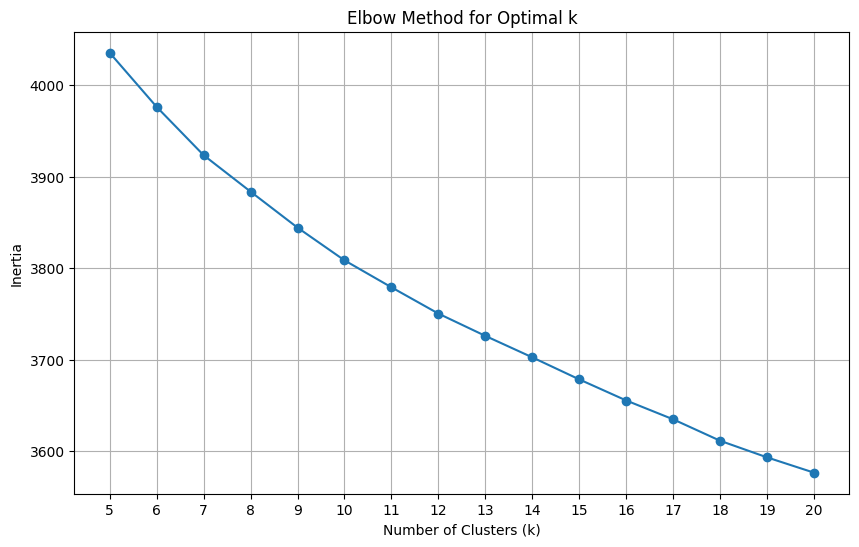

Based on the plot, we will proceed with OPTIMAL_K = 12

--- K-Means: Training final model with k=12 and creating features ---
Shape of new K-Means features for train set: (8299, 12)
Shape of new K-Means features for test set: (2075, 12)

Combining features, embeddings, AND K-Means features...
Final X_train_final shape: (8299, 404), y_train_np shape: (8299,)
Input dimension for model: 404, Number of classes: 13

--- Training Configuration: model_1_small_1layer (1/9) ---
Building model: model_1_small_1layer


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,389 (52.30 KB)

 Trainable params: 13,389 (52.30 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_1_small_1layer...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.3878 - loss: 2.3901 - val_accuracy: 0.5847 - val_loss: 1.9011
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5905 - loss: 1.7579 - val_accuracy: 0.5888 - val_loss: 1.4342
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6087 - loss: 1.3769 - val_accuracy: 0.6040 - val_loss: 1.2778
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6113 - loss: 1.3014 - val_accuracy: 0.6289 - val_loss: 1.2010
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6576 - loss: 1.1806 - val_accuracy: 0.6514 - val_loss: 1.1546
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6654 - loss: 1.1338 - val_accuracy: 0.6627 - val_loss: 1.1239
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6768 - loss: 1.1161 - val_accuracy: 0.6667 - val_loss: 1.0996
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        25,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,765 (104.55 KB)

 Trainable params: 26,765 (104.55 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_2_medium_1layer...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2051 - loss: 2.4913 - val_accuracy: 0.6530 - val_loss: 1.9571
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6519 - loss: 1.7769 - val_accuracy: 0.6394 - val_loss: 1.3558
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6563 - loss: 1.3316 - val_accuracy: 0.6643 - val_loss: 1.1872
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6656 - loss: 1.2135 - val_accuracy: 0.6771 - val_loss: 1.1267
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6836 - loss: 1.1314 - val_accuracy: 0.6795 - val_loss: 1.0909
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6858 - loss: 1.0859 - val_accuracy: 0.6819 - val_loss: 1.0660
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6824 - loss: 1.0917 - val_accuracy: 0.6843 - val_loss: 1.0464
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - ac

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,445 (56.43 KB)

 Trainable params: 14,445 (56.43 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_3_small_2layer...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.0958 - loss: 2.5252 - val_accuracy: 0.5815 - val_loss: 2.1450
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5761 - loss: 1.9620 - val_accuracy: 0.5960 - val_loss: 1.4149
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6151 - loss: 1.3988 - val_accuracy: 0.6313 - val_loss: 1.2297
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6410 - loss: 1.2833 - val_accuracy: 0.6651 - val_loss: 1.1568
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6522 - loss: 1.2296 - val_accuracy: 0.6731 - val_loss: 1.1224
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6790 - loss: 1.1489 - val_accuracy: 0.6795 - val_loss: 1.0984
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6747 - loss: 1.1308 - val_accuracy: 0.6803 - val_loss: 1.0828
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        25,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,429 (111.05 KB)

 Trainable params: 28,429 (111.05 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_4_medium_2layer_high_lr...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5327 - loss: 1.6784 - val_accuracy: 0.6779 - val_loss: 1.0561
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6826 - loss: 1.0530 - val_accuracy: 0.6892 - val_loss: 1.0024
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7022 - loss: 0.9682 - val_accuracy: 0.7012 - val_loss: 0.9643
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6970 - loss: 0.9385 - val_accuracy: 0.7060 - val_loss: 0.9187
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7205 - loss: 0.8801 - val_accuracy: 0.7076 - val_loss: 0.8984
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7194 - loss: 0.8441 - val_accuracy: 0.7052 - val_loss: 0.8835
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7194 - loss: 0.8381 - val_accuracy: 0.7100 - val_loss: 0.8768
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/s

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        51,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,517 (209.05 KB)

 Trainable params: 53,517 (209.05 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_5_large_1layer...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4045 - loss: 2.2525 - val_accuracy: 0.6072 - val_loss: 1.4705
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6351 - loss: 1.3695 - val_accuracy: 0.6466 - val_loss: 1.1924
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6641 - loss: 1.1747 - val_accuracy: 0.6618 - val_loss: 1.1233
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6833 - loss: 1.0935 - val_accuracy: 0.6707 - val_loss: 1.0830
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6817 - loss: 1.0793 - val_accuracy: 0.6755 - val_loss: 1.0560
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6942 - loss: 1.0289 - val_accuracy: 0.6803 - val_loss: 1.0331
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6898 - loss: 1.0238 - val_accuracy: 0.6819 - val_loss: 1.0156
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        51,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,941 (238.05 KB)

 Trainable params: 60,941 (238.05 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_6_medium_2layer_v2...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4086 - loss: 2.1989 - val_accuracy: 0.6426 - val_loss: 1.2642
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6719 - loss: 1.2430 - val_accuracy: 0.6570 - val_loss: 1.1346
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6839 - loss: 1.1326 - val_accuracy: 0.6675 - val_loss: 1.0858
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6778 - loss: 1.1107 - val_accuracy: 0.6779 - val_loss: 1.0568
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6926 - loss: 1.0497 - val_accuracy: 0.6811 - val_loss: 1.0442
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6922 - loss: 1.0420 - val_accuracy: 0.6835 - val_loss: 1.0267
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6985 - loss: 1.0096 - val_accuracy: 0.6843 - val_loss: 1.0093
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        25,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,749 (112.30 KB)

 Trainable params: 28,749 (112.30 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_7_small_3layer_taper...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.2718 - loss: 2.4235 - val_accuracy: 0.5880 - val_loss: 1.7610
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5719 - loss: 1.6240 - val_accuracy: 0.5831 - val_loss: 1.2830
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6029 - loss: 1.3585 - val_accuracy: 0.6442 - val_loss: 1.1751
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6524 - loss: 1.2415 - val_accuracy: 0.6651 - val_loss: 1.1267
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6642 - loss: 1.2041 - val_accuracy: 0.6795 - val_loss: 1.0991
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6769 - loss: 1.1462 - val_accuracy: 0.6827 - val_loss: 1.0827
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6798 - loss: 1.1441 - val_accuracy: 0.6803 - val_loss: 1.0746
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        51,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,605 (244.55 KB)

 Trainable params: 62,605 (244.55 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_8_medium_3layer_taper...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.2392 - loss: 2.4187 - val_accuracy: 0.6321 - val_loss: 1.4311
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6407 - loss: 1.3712 - val_accuracy: 0.6554 - val_loss: 1.1816
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6696 - loss: 1.2081 - val_accuracy: 0.6723 - val_loss: 1.1225
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6756 - loss: 1.1414 - val_accuracy: 0.6763 - val_loss: 1.0966
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6808 - loss: 1.1140 - val_accuracy: 0.6763 - val_loss: 1.0803
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6905 - loss: 1.0735 - val_accuracy: 0.6795 - val_loss: 1.0673
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6885 - loss: 1.0475 - val_accuracy: 0.6771 - val_loss: 1.0564
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       103,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,677 (569.05 KB)

 Trainable params: 145,677 (569.05 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_9_large_3layer_taper_high_lr...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5737 - loss: 1.5980 - val_accuracy: 0.6795 - val_loss: 1.0513
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6849 - loss: 1.0667 - val_accuracy: 0.6940 - val_loss: 0.9987
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6988 - loss: 0.9526 - val_accuracy: 0.7092 - val_loss: 0.9512
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7010 - loss: 0.9487 - val_accuracy: 0.7108 - val_loss: 0.9347
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7104 - loss: 0.8980 - val_accuracy: 0.7124 - val_loss: 0.8928
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7177 - loss: 0.8723 - val_accuracy: 0.7028 - val_loss: 0.9079
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7182 - loss: 0.8427 - val_accuracy: 0.7076 - val_loss: 0.8733
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [3]:
# ==============================================================================
# INSTALLATIONS (Run once per new Colab runtime)
# ==============================================================================
# !pip install -U sentence-transformers transformers spacy tensorflow keras scikit-learn --progress-bar off
# !python -m spacy download it_core_news_sm

# ==============================================================================
# MAIN SCRIPT
# ==============================================================================
import os
import gc
import re
import shutil
import time

import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder # <<< K-MEANS: Added OneHotEncoder
from sklearn.cluster import KMeans # <<< K-MEANS: Added KMeans
import matplotlib.pyplot as plt # <<< K-MEANS: Added for plotting
from google.colab import drive

def initial_gpu_check():
    print(f"TensorFlow Version: {tf.__version__}")
    print(f"Keras Version: {keras.__version__}")

    gpus = tf.config.list_physical_devices('GPU')
    print(f"Physical GPUs available: {gpus}")

    if gpus:
        try:
            print("Attempting to set memory growth for GPUs...")
            for gpu_device in gpus:
                tf.config.experimental.set_memory_growth(gpu_device, True)
            print("GPU memory growth set successfully.")

            print("Performing a simple TensorFlow operation on GPU...")
            with tf.device('/GPU:0'): # Explicitly use the first GPU
                a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
                b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
                c = tf.matmul(a, b)
            print(f"Simple TF GPU matmul test successful. Result matrix:\n{c.numpy()}")
            print("Successfully initialized and tested GPU.")
            return True
        except RuntimeError as e:
            print(f"!!!!!!!! ERROR DURING GPU INITIALIZATION OR TEST: {e} !!!!!!!!")
            print(f"Colab environment issue. Disconnect/delete runtime, ensure GPU, rerun installs & script.")
            return False
    else:
        print(f"!!!!!!!! NO GPU DETECTED BY TENSORFLOW !!!!!!!!")
        print("Ensure 'GPU' is selected in 'Runtime' -> 'Change runtime type'.")
        return False

if not initial_gpu_check():
    raise SystemExit("GPU initialization failed. Stopping script.")

drive.mount('/content/drive', force_remount=True)

# Using a new results file to distinguish from the non-KMeans run
BASE_DIR = '/content/drive/MyDrive/tayyab'
EMB_DIR = os.path.join(BASE_DIR, 'embeddings_fe')
RESULT_CSV = os.path.join(BASE_DIR, 'deep_classifier_results_with_kmeans_v1.csv') # Versioning

os.makedirs(EMB_DIR, exist_ok=True)

if os.path.exists(RESULT_CSV):
    print(f"Removing existing results file: {RESULT_CSV}")
    os.remove(RESULT_CSV)

# --- Data Loading and Preprocessing (Unchanged) ---
print("Loading and cleaning data...")
csv_path = os.path.join(BASE_DIR, 'italian_crime_news.csv')
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV file not found at: {csv_path}")
df = pd.read_csv(csv_path)
df.dropna(subset=['text'], inplace=True)
df['text'] = df['text'].astype(str)
texts_full = df['text'].tolist()
labels_full = df['word2vec_tag'].tolist()

del df; gc.collect()

print("Encoding labels...")
en = LabelEncoder()
y_encoded_full = en.fit_transform(labels_full)
num_classes = len(en.classes_)

X_train_texts, X_test_texts, y_train_np, y_test_np = train_test_split(
    texts_full, y_encoded_full, test_size=0.2, stratify=y_encoded_full, random_state=42
)
del texts_full, labels_full, y_encoded_full; gc.collect()


# --- spaCy Feature Extraction (Unchanged) ---
print("Setting up spaCy for feature extraction...")
components_to_exclude = ["parser", "tagger", "attribute_ruler", "lemmatizer"]
try:
    nlp = spacy.load('it_core_news_sm', exclude=components_to_exclude)
    print(f"spaCy pipeline loaded with components: {nlp.pipe_names}")
    if not (any(comp in nlp.pipe_names for comp in ['senter', 'sentencizer'])):
        nlp.add_pipe("sentencizer", first=True)
except OSError:
    import subprocess
    subprocess.run(['python', '-m', 'spacy', 'download', 'it_core_news_sm'])
    nlp = spacy.load('it_core_news_sm', exclude=components_to_exclude)
    if not (any(comp in nlp.pipe_names for comp in ['senter', 'sentencizer'])):
        nlp.add_pipe("sentencizer", first=True)

crime_kw = {'omicidio','furto','arresto','rapina','droga','corruzione'}
kw_pattern = re.compile(r"\b(?:" + "|".join(map(re.escape, crime_kw)) + r")\b", flags=re.IGNORECASE)

def extract_feats(input_texts):
    feats = []
    for doc in nlp.pipe(input_texts, batch_size=128):
        t = doc.text
        num_chars = len(t); num_words = len(doc)
        alpha = [tok for tok in doc if tok.is_alpha]
        avg_w = np.mean([len(tok.text) for tok in alpha]) if alpha else 0
        sents = sum(1 for _ in doc.sents)
        up = sum(1 for tok in doc if tok.is_upper and tok.is_alpha)
        stp = sum(1 for tok in doc if tok.is_stop)
        ents = len(doc.ents)
        has_kw = int(bool(kw_pattern.search(t)))
        feats.append([num_chars, num_words, avg_w, sents, up, stp, ents, has_kw])
    return np.array(feats, dtype=np.float32)

train_feats_fpath = os.path.join(EMB_DIR, 'train_feats.npy')
if os.path.exists(train_feats_fpath):
    print("Loading TRAIN engineered features from cache...")
    X_train_feats = np.load(train_feats_fpath)
else:
    print("Extracting TRAIN engineered features ..."); X_train_feats = extract_feats(X_train_texts)
    print("Saving TRAIN engineered features ..."); np.save(train_feats_fpath, X_train_feats)

test_feats_fpath = os.path.join(EMB_DIR, 'test_feats.npy')
if os.path.exists(test_feats_fpath):
    print("Loading TEST engineered features from cache...")
    X_test_feats = np.load(test_feats_fpath)
else:
    print("Extracting TEST engineered features ..."); X_test_feats = extract_feats(X_test_texts)
    print("Saving TEST engineered features ..."); np.save(test_feats_fpath, X_test_feats)

scaler_feats = StandardScaler()
X_train_feats = scaler_feats.fit_transform(X_train_feats)
X_test_feats  = scaler_feats.transform(X_test_feats)


# --- SentenceTransformer Embedding Generation (Unchanged) ---
print("Setting up SentenceTransformer model...")
try:
    sent_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
except Exception as e: print(f"Error loading SentenceTransformer model: {e}"); raise

def get_emb(name, input_texts_list, model_emb_dir):
    cache = os.path.join(model_emb_dir, f'{name}_emb_manual.npy')
    if os.path.exists(cache):
        print(f"Loading {name} embeddings from cache: {cache}"); return np.load(cache)

    print(f"Generating {name} embeddings...")
    emb_device = 'cuda' if tf.config.list_physical_devices('GPU') else 'cpu'
    embeddings = sent_model.encode(
        input_texts_list, batch_size=32, show_progress_bar=True,
        device=emb_device, normalize_embeddings=True
    )
    print(f"Saving {name} embeddings to cache: {cache}"); np.save(cache, embeddings)
    return embeddings

emb_train = get_emb('train', X_train_texts, EMB_DIR)
emb_test  = get_emb('test',  X_test_texts, EMB_DIR)


print("Releasing SentenceTransformer model and text lists from memory...")
del sent_model; del X_train_texts; del X_test_texts; gc.collect()

# ==============================================================================
# <<< K-MEANS INTEGRATION START >>>
# ==============================================================================

# --- 1. Find the optimal number of clusters (k) using the Elbow Method ---
print("\n--- K-Means: Finding Optimal k using Elbow Method ---")
# Note: This can be slow on large datasets. We'll test a range of k values.
# For a real project, you might do this once and then hard-code the best k.
inertia = []
k_range = range(5, 21) # Test a reasonable range of clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, verbose=0)
    kmeans.fit(emb_train) # Fit only on training data
    inertia.append(kmeans.inertia_)
    print(f"Completed k={k}, inertia={kmeans.inertia_:.2f}")

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Based on the plot, we manually choose the "elbow" point.
# Let's assume the elbow appears around k=12 for this example.
OPTIMAL_K = 12
print(f"Based on the plot, we will proceed with OPTIMAL_K = {OPTIMAL_K}\n")

# --- 2. Create the cluster features ---
print(f"--- K-Means: Training final model with k={OPTIMAL_K} and creating features ---")
kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)

# Fit on training embeddings and create cluster labels for train set
train_cluster_labels = kmeans_final.fit_predict(emb_train)

# Predict cluster labels for the test set
test_cluster_labels = kmeans_final.predict(emb_test)

# --- 3. One-Hot Encode the cluster labels ---
# Reshape labels to be a 2D array for the encoder
train_cluster_labels = train_cluster_labels.reshape(-1, 1)
test_cluster_labels = test_cluster_labels.reshape(-1, 1)

# Fit the encoder on the training cluster labels and transform both sets
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_cluster_feats = ohe.fit_transform(train_cluster_labels)
X_test_cluster_feats = ohe.transform(test_cluster_labels)

print(f"Shape of new K-Means features for train set: {X_train_cluster_feats.shape}")
print(f"Shape of new K-Means features for test set: {X_test_cluster_feats.shape}")

# ==============================================================================
# <<< K-MEANS INTEGRATION END >>>
# ==============================================================================


print("\nCombining features, embeddings, AND K-Means features...")
# <<< K-MEANS: MODIFIED THIS LINE >>>
X_train_final = np.hstack([emb_train, X_train_feats, X_train_cluster_feats])
del emb_train, X_train_feats, X_train_cluster_feats; gc.collect()

# <<< K-MEANS: MODIFIED THIS LINE >>>
X_test_final = np.hstack([emb_test, X_test_feats, X_test_cluster_feats])
del emb_test, X_test_feats, X_test_cluster_feats; gc.collect()


# This will now be larger (original dim + number of clusters)
input_dim = X_train_final.shape[1]

print(f"Final X_train_final shape: {X_train_final.shape}, y_train_np shape: {y_train_np.shape}")
print(f"Input dimension for model: {input_dim}, Number of classes: {num_classes}")


# --- Model Building and Training (Unchanged) ---
def build_and_compile_model(params_dict, current_input_dim, current_num_classes):
    keras.backend.clear_session(); gc.collect()
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(current_input_dim,)))
    model.add(keras.layers.Dense(units=params_dict.get('units_0', 32), activation='relu'))
    model.add(keras.layers.Dropout(rate=params_dict.get('dropout_0', 0.2)))
    if params_dict.get('num_hidden_layers', 1) >= 2:
        model.add(keras.layers.Dense(units=params_dict.get('units_1', 32), activation='relu'))
        model.add(keras.layers.Dropout(rate=params_dict.get('dropout_1', 0.2)))
    if params_dict.get('num_hidden_layers', 1) >= 3:
        model.add(keras.layers.Dense(units=params_dict.get('units_2', 16), activation='relu'))
        model.add(keras.layers.Dropout(rate=params_dict.get('dropout_2', 0.1)))
    model.add(keras.layers.Dense(current_num_classes, activation='softmax'))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=params_dict.get('learning_rate', 1e-4)),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model

model_configurations = [
    {'name': 'model_1_small_1layer', 'units_0': 32, 'dropout_0': 0.2, 'num_hidden_layers': 1, 'learning_rate': 1e-4},
    {'name': 'model_2_medium_1layer', 'units_0': 64, 'dropout_0': 0.3, 'num_hidden_layers': 1, 'learning_rate': 1e-4},
    {'name': 'model_3_small_2layer', 'units_0': 32, 'dropout_0': 0.2, 'units_1': 32, 'dropout_1': 0.2, 'num_hidden_layers': 2, 'learning_rate': 1e-4},
    {'name': 'model_4_medium_2layer_high_lr', 'units_0': 64, 'dropout_0': 0.3, 'units_1': 32, 'dropout_1': 0.2, 'num_hidden_layers': 2, 'learning_rate': 1e-3},
    {'name': 'model_5_large_1layer', 'units_0': 128, 'dropout_0': 0.3, 'num_hidden_layers': 1, 'learning_rate': 1e-4},
    {'name': 'model_6_medium_2layer_v2', 'units_0': 128, 'dropout_0': 0.3, 'units_1': 64, 'dropout_1': 0.2, 'num_hidden_layers': 2, 'learning_rate': 1e-4},
    {'name': 'model_7_small_3layer_taper', 'units_0': 64, 'dropout_0': 0.2, 'units_1': 32, 'dropout_1': 0.2, 'units_2': 16, 'dropout_2': 0.1, 'num_hidden_layers': 3, 'learning_rate': 1e-4},
    {'name': 'model_8_medium_3layer_taper', 'units_0': 128, 'dropout_0': 0.3, 'units_1': 64, 'dropout_1': 0.2, 'units_2': 32, 'dropout_2': 0.1, 'num_hidden_layers': 3, 'learning_rate': 1e-4},
    {'name': 'model_9_large_3layer_taper_high_lr', 'units_0': 256, 'dropout_0': 0.4, 'units_1': 128, 'dropout_1': 0.3, 'units_2': 64, 'dropout_2': 0.2, 'num_hidden_layers': 3, 'learning_rate': 5e-4},
]

all_results = []
EPOCHS_PER_MODEL = 15
BATCH_SIZE_TRAIN = 32

for i, config in enumerate(model_configurations):
    print(f"\n--- Training Configuration: {config['name']} ({i+1}/{len(model_configurations)}) ---")
    print(f"Building model: {config['name']}")
    model = build_and_compile_model(config, input_dim, num_classes)
    model.summary()
    early_stop_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
    history = None; training_successful = False
    try:
        print(f"Starting training for {config['name']}...")
        time.sleep(1)
        history = model.fit(
            X_train_final, y_train_np,
            epochs=EPOCHS_PER_MODEL,
            batch_size=BATCH_SIZE_TRAIN,
            validation_split=0.15,
            callbacks=[early_stop_cb],
            verbose=1
        )
        print(f"Training completed for {config['name']}.")
        training_successful = True
    except Exception as e_generic:
        print(f"!!!!!!!! GENERIC ERROR during training of {config['name']}: {e_generic} !!!!!!!!")
        import traceback; traceback.print_exc()

    if training_successful and history:
        print(f"Evaluating {config['name']} on test set...")
        test_loss, test_acc = model.evaluate(X_test_final, y_test_np, batch_size=BATCH_SIZE_TRAIN, verbose=0)
        print(f"Test Results for {config['name']} - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
        final_val_loss = history.history['val_loss'][-1] if history.history and 'val_loss' in history.history and history.history['val_loss'] else None
        final_val_accuracy = history.history['val_accuracy'][-1] if history.history and 'val_accuracy' in history.history and history.history['val_accuracy'] else None
        current_result = {
            'model_name': config['name'], **config,
            'test_loss': test_loss, 'test_accuracy': test_acc,
            'final_val_loss': final_val_loss, 'final_val_accuracy': final_val_accuracy,
            'epochs_run': len(history.history['loss'])
        }
        all_results.append(current_result)
    else:
        print(f"Skipping evaluation for {config['name']} due to training failure or no history.")
        current_result = { 'model_name': config['name'], **config, 'test_loss': None, 'test_accuracy': None, 'final_val_loss': None, 'final_val_accuracy': None, 'epochs_run': 0 }
        all_results.append(current_result)

    del model; del history; gc.collect(); keras.backend.clear_session()
    print(f"Cleaned up after {config['name']}. Waiting a bit...")
    time.sleep(2)

if all_results:
    df_all_results = pd.DataFrame(all_results)
    print("\n--- All Model Results (with K-Means feature) ---"); print(df_all_results)
    df_all_results.to_csv(RESULT_CSV, index=False)
    print(f"All results saved to {RESULT_CSV}")
else:
    print("No models were processed or produced results.")

print("Script finished.")

TensorFlow Version: 2.18.0
Keras Version: 3.8.0
PyTorch Version: 2.6.0+cu124
Physical GPUs available (TensorFlow): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
PyTorch CUDA available. Device: Tesla T4
Attempting to set memory growth for GPUs (TensorFlow)...
GPU memory growth set successfully (TensorFlow).
Performing a simple TensorFlow operation on GPU...
Simple TF GPU matmul test successful. Result matrix:
[[22. 28.]
 [49. 64.]]
Mounted at /content/drive
Loading and cleaning data...
Encoding labels...
Setting up spaCy for feature extraction...
Setting up Hugging Face model (intfloat/multilingual-e5-large-instruct)...


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/235k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Generating train embeddings with dbmdz/bert-base-italian-cased...
Using device: cuda for embeddings.


Encoding train batches:   0%|          | 0/519 [00:00<?, ?it/s]

Saving train embeddings to cache: /content/drive/MyDrive/tayyab/embeddings_fe_bert_base_italian_cased/train_emb_dbmdz_bert-base-italian-cased.npy
Generating test embeddings with dbmdz/bert-base-italian-cased...
Using device: cuda for embeddings.


Encoding test batches:   0%|          | 0/130 [00:00<?, ?it/s]

Saving test embeddings to cache: /content/drive/MyDrive/tayyab/embeddings_fe_bert_base_italian_cased/test_emb_dbmdz_bert-base-italian-cased.npy
Releasing Hugging Face model and text lists from memory...

--- K-Means: Finding Optimal k using Elbow Method ---
Completed k=5, inertia=424.86
Completed k=7, inertia=406.48
Completed k=9, inertia=391.83
Completed k=11, inertia=385.04
Completed k=13, inertia=376.96
Completed k=15, inertia=371.19
Completed k=17, inertia=367.09
Completed k=19, inertia=358.86
Completed k=21, inertia=355.39
Completed k=23, inertia=351.84
Completed k=25, inertia=348.58


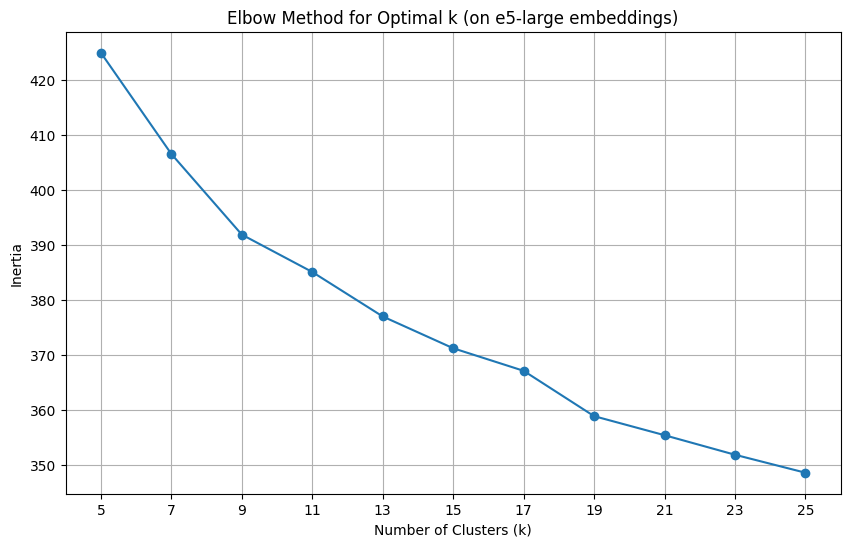

Based on the plot, we will proceed with OPTIMAL_K = 16

--- K-Means: Training final model with k=16 and creating features ---
Shape of new K-Means features for train set: (8299, 16)

Combining features, embeddings, AND K-Means features...
Final X_train_final shape: (8299, 792), y_train_np shape: (8299,)
Input dimension for model: 792, Number of classes: 13

--- Training Configuration: model_1_small_1layer (1/9) ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        25,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,805 (100.80 KB)

 Trainable params: 25,805 (100.80 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_1_small_1layer...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2262 - loss: 2.5013 - val_accuracy: 0.6169 - val_loss: 2.0996
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6164 - loss: 1.9644 - val_accuracy: 0.6201 - val_loss: 1.5415
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6314 - loss: 1.4937 - val_accuracy: 0.6217 - val_loss: 1.2839
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6399 - loss: 1.2965 - val_accuracy: 0.6418 - val_loss: 1.2083
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6439 - loss: 1.2529 - val_accuracy: 0.6482 - val_loss: 1.1749
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6503 - loss: 1.2246 - val_accuracy: 0.6522 - val_loss: 1.1530
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6542 - loss: 1.2096 - val_accuracy: 0.6562 - val_loss: 1.1389
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        50,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,597 (201.55 KB)

 Trainable params: 51,597 (201.55 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_2_medium_1layer...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3802 - loss: 2.2916 - val_accuracy: 0.5847 - val_loss: 1.5724
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5965 - loss: 1.4788 - val_accuracy: 0.6161 - val_loss: 1.2561
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6292 - loss: 1.2836 - val_accuracy: 0.6474 - val_loss: 1.1906
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6525 - loss: 1.2190 - val_accuracy: 0.6514 - val_loss: 1.1580
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6681 - loss: 1.1728 - val_accuracy: 0.6594 - val_loss: 1.1351
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6767 - loss: 1.1380 - val_accuracy: 0.6659 - val_loss: 1.1187
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6783 - loss: 1.1207 - val_accuracy: 0.6675 - val_loss: 1.1053
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - ac

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        25,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,861 (104.93 KB)

 Trainable params: 26,861 (104.93 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_3_small_2layer...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2343 - loss: 2.5291 - val_accuracy: 0.5960 - val_loss: 2.1565
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6003 - loss: 1.9545 - val_accuracy: 0.5863 - val_loss: 1.4309
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6005 - loss: 1.4603 - val_accuracy: 0.6016 - val_loss: 1.2865
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6118 - loss: 1.3451 - val_accuracy: 0.6321 - val_loss: 1.2327
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6435 - loss: 1.2656 - val_accuracy: 0.6506 - val_loss: 1.1988
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6463 - loss: 1.2570 - val_accuracy: 0.6570 - val_loss: 1.1771
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6597 - loss: 1.2191 - val_accuracy: 0.6602 - val_loss: 1.1599
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        50,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,261 (208.05 KB)

 Trainable params: 53,261 (208.05 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_4_medium_2layer_high_lr...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5154 - loss: 1.8111 - val_accuracy: 0.6715 - val_loss: 1.1242
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6729 - loss: 1.1431 - val_accuracy: 0.6787 - val_loss: 1.0446
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6842 - loss: 1.0689 - val_accuracy: 0.6980 - val_loss: 0.9846
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6961 - loss: 0.9890 - val_accuracy: 0.7028 - val_loss: 0.9401
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6963 - loss: 0.9485 - val_accuracy: 0.7020 - val_loss: 0.8971
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7196 - loss: 0.8748 - val_accuracy: 0.7108 - val_loss: 0.8722
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7294 - loss: 0.8556 - val_accuracy: 0.7253 - val_loss: 0.8304
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/s

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       101,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,181 (403.05 KB)

 Trainable params: 103,181 (403.05 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_5_large_1layer...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4545 - loss: 2.2071 - val_accuracy: 0.6177 - val_loss: 1.3942
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6303 - loss: 1.3459 - val_accuracy: 0.6426 - val_loss: 1.2057
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6520 - loss: 1.2059 - val_accuracy: 0.6490 - val_loss: 1.1549
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6728 - loss: 1.1480 - val_accuracy: 0.6602 - val_loss: 1.1234
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6707 - loss: 1.1358 - val_accuracy: 0.6602 - val_loss: 1.1024
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6850 - loss: 1.0839 - val_accuracy: 0.6635 - val_loss: 1.0861
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6835 - loss: 1.0720 - val_accuracy: 0.6699 - val_loss: 1.0719
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       101,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,605 (432.05 KB)

 Trainable params: 110,605 (432.05 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_6_medium_2layer_v2...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.4010 - loss: 2.2353 - val_accuracy: 0.5847 - val_loss: 1.3152
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6332 - loss: 1.2949 - val_accuracy: 0.6490 - val_loss: 1.1763
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6691 - loss: 1.1908 - val_accuracy: 0.6562 - val_loss: 1.1413
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6832 - loss: 1.1400 - val_accuracy: 0.6610 - val_loss: 1.1167
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6802 - loss: 1.1362 - val_accuracy: 0.6643 - val_loss: 1.1003
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6767 - loss: 1.1154 - val_accuracy: 0.6691 - val_loss: 1.0817
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6736 - loss: 1.1169 - val_accuracy: 0.6651 - val_loss: 1.0650
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        50,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,581 (209.30 KB)

 Trainable params: 53,581 (209.30 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_7_small_3layer_taper...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.1783 - loss: 2.5605 - val_accuracy: 0.5823 - val_loss: 2.3648
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5527 - loss: 2.2230 - val_accuracy: 0.5831 - val_loss: 1.7605
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5774 - loss: 1.7573 - val_accuracy: 0.5831 - val_loss: 1.5612
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5802 - loss: 1.6078 - val_accuracy: 0.5831 - val_loss: 1.4707
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5740 - loss: 1.5249 - val_accuracy: 0.5831 - val_loss: 1.4102
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5895 - loss: 1.4389 - val_accuracy: 0.5831 - val_loss: 1.3595
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5798 - loss: 1.4074 - val_accuracy: 0.5831 - val_loss: 1.3097
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       101,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,269 (438.55 KB)

 Trainable params: 112,269 (438.55 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_8_medium_3layer_taper...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.2785 - loss: 2.3786 - val_accuracy: 0.5847 - val_loss: 1.4016
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6117 - loss: 1.4071 - val_accuracy: 0.6434 - val_loss: 1.2297
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6629 - loss: 1.2628 - val_accuracy: 0.6490 - val_loss: 1.1785
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6654 - loss: 1.2154 - val_accuracy: 0.6522 - val_loss: 1.1502
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6811 - loss: 1.1675 - val_accuracy: 0.6562 - val_loss: 1.1265
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6851 - loss: 1.1309 - val_accuracy: 0.6610 - val_loss: 1.1092
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6900 - loss: 1.0973 - val_accuracy: 0.6675 - val_loss: 1.0951
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       203,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,005 (957.05 KB)

 Trainable params: 245,005 (957.05 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for model_9_large_3layer_taper_high_lr...
Epoch 1/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.4913 - loss: 1.7474 - val_accuracy: 0.6586 - val_loss: 1.1171
Epoch 2/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6772 - loss: 1.1086 - val_accuracy: 0.6819 - val_loss: 1.0531
Epoch 3/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6948 - loss: 1.0320 - val_accuracy: 0.6795 - val_loss: 1.0226
Epoch 4/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6873 - loss: 1.0058 - val_accuracy: 0.7076 - val_loss: 0.9382
Epoch 5/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7036 - loss: 0.9557 - val_accuracy: 0.7149 - val_loss: 0.9007
Epoch 6/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7157 - loss: 0.8829 - val_accuracy: 0.7133 - val_loss: 0.8766
Epoch 7/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7247 - loss: 0.8453 - val_accuracy: 0.7133 - val_loss: 0.8461
Epoch 8/15
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [4]:
# ==============================================================================
# INSTALLATIONS (Run once per new Colab runtime)
# ==============================================================================
# !pip install -U sentence-transformers transformers spacy tensorflow keras torch tqdm scikit-learn matplotlib --progress-bar off
# !python -m spacy download it_core_news_sm

# ==============================================================================
# MAIN SCRIPT
# ==============================================================================
import os
import gc
import re
import shutil
import time

import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import spacy
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder # <<< K-MEANS: Added OneHotEncoder
from sklearn.cluster import KMeans # <<< K-MEANS: Added KMeans
import matplotlib.pyplot as plt # <<< K-MEANS: Added for plotting
from google.colab import drive

def initial_gpu_check():
    print(f"TensorFlow Version: {tf.__version__}")
    print(f"Keras Version: {keras.__version__}")
    print(f"PyTorch Version: {torch.__version__}")

    gpus_tf = tf.config.list_physical_devices('GPU')
    print(f"Physical GPUs available (TensorFlow): {gpus_tf}")

    if torch.cuda.is_available():
        print(f"PyTorch CUDA available. Device: {torch.cuda.get_device_name(0)}")
    else:
        print("PyTorch CUDA not available.")

    if gpus_tf:
        try:
            print("Attempting to set memory growth for GPUs (TensorFlow)...")
            for gpu_device in gpus_tf:
                tf.config.experimental.set_memory_growth(gpu_device, True)
            print("GPU memory growth set successfully (TensorFlow).")
            print("Performing a simple TensorFlow operation on GPU...")
            with tf.device('/GPU:0'):
                a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
                b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
                c = tf.matmul(a, b)
            print(f"Simple TF GPU matmul test successful. Result matrix:\n{c.numpy()}")
            return True
        except RuntimeError as e:
            print(f"!!!!!!!! ERROR DURING TENSORFLOW GPU INITIALIZATION OR TEST: {e} !!!!!!!!")
            return False
    else:
        print("!!!!!!!! NO GPU DETECTED BY TENSORFLOW !!!!!!!!")
        return False

if not initial_gpu_check():
    raise SystemExit("GPU initialization failed. Stopping script.")

drive.mount('/content/drive', force_remount=True)

BASE_DIR = '/content/drive/MyDrive/tayyab'
EMB_DIR = os.path.join(BASE_DIR, 'embeddings_fe_bert_base_italian_cased')
# <<< K-MEANS: Using a new results file for this experiment >>>
RESULT_CSV = os.path.join(BASE_DIR, 'deep_classifier_results_bert_base_italian_cased_with_kmeans.csv')

os.makedirs(EMB_DIR, exist_ok=True)

if os.path.exists(RESULT_CSV):
    print(f"Removing existing results file: {RESULT_CSV}")
    os.remove(RESULT_CSV)


# --- Data Loading and Preprocessing (Unchanged) ---
print("Loading and cleaning data...")
csv_path = os.path.join(BASE_DIR, 'italian_crime_news.csv')
df = pd.read_csv(csv_path)
df.dropna(subset=['text'], inplace=True)
df['text'] = df['text'].astype(str)
texts_full = df['text'].tolist()
labels_full = df['word2vec_tag'].tolist()
del df; gc.collect()

print("Encoding labels...")
en = LabelEncoder()
y_encoded_full = en.fit_transform(labels_full)
num_classes = len(en.classes_)

X_train_texts, X_test_texts, y_train_np, y_test_np = train_test_split(
    texts_full, y_encoded_full, test_size=0.2, stratify=y_encoded_full, random_state=42
)
del texts_full, labels_full, y_encoded_full; gc.collect()


# --- spaCy Feature Extraction (Unchanged) ---
print("Setting up spaCy for feature extraction...")
components_to_exclude = ["parser", "tagger", "attribute_ruler", "lemmatizer"]
try:
    nlp = spacy.load('it_core_news_sm', exclude=components_to_exclude)
    if not (any(comp in nlp.pipe_names for comp in ['senter', 'sentencizer'])):
        nlp.add_pipe("sentencizer", first=True)
except OSError:
    import subprocess
    subprocess.run(['python', '-m', 'spacy', 'download', 'it_core_news_sm'])
    nlp = spacy.load('it_core_news_sm', exclude=components_to_exclude)
    if not (any(comp in nlp.pipe_names for comp in ['senter', 'sentencizer'])):
        nlp.add_pipe("sentencizer", first=True)

crime_kw = {'omicidio','furto','arresto','rapina','droga','corruzione'}
kw_pattern = re.compile(r"\b(?:" + "|".join(map(re.escape, crime_kw)) + r")\b", flags=re.IGNORECASE)

def extract_feats(input_texts):
    feats = []
    for doc in nlp.pipe(input_texts, batch_size=128):
        t = doc.text; num_chars = len(t); num_words = len(doc)
        alpha = [tok for tok in doc if tok.is_alpha]
        avg_w = np.mean([len(tok.text) for tok in alpha]) if alpha else 0
        sents = sum(1 for _ in doc.sents); up = sum(1 for tok in doc if tok.is_upper and tok.is_alpha)
        stp = sum(1 for tok in doc if tok.is_stop); ents = len(doc.ents)
        has_kw = int(bool(kw_pattern.search(t)))
        feats.append([num_chars, num_words, avg_w, sents, up, stp, ents, has_kw])
    return np.array(feats, dtype=np.float32)

train_feats_fpath = os.path.join(EMB_DIR, 'train_feats.npy')
if os.path.exists(train_feats_fpath):
    X_train_feats = np.load(train_feats_fpath)
else:
    X_train_feats = extract_feats(X_train_texts); np.save(train_feats_fpath, X_train_feats)

test_feats_fpath = os.path.join(EMB_DIR, 'test_feats.npy')
if os.path.exists(test_feats_fpath):
    X_test_feats = np.load(test_feats_fpath)
else:
    X_test_feats = extract_feats(X_test_texts); np.save(test_feats_fpath, X_test_feats)

scaler_feats = StandardScaler()
X_train_feats = scaler_feats.fit_transform(X_train_feats)
X_test_feats  = scaler_feats.transform(X_test_feats)


# --- Hugging Face Embedding Generation (Unchanged) ---
print("Setting up Hugging Face model (intfloat/multilingual-e5-large-instruct)...")
try:
  # tokenizer_b = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large-instruct')
   # model_b = AutoModel.from_pretrained('intfloat/multilingual-e5-large-instruct')
    tokenizer_b = AutoTokenizer.from_pretrained('dbmdz/bert-base-italian-cased')
    model_b = AutoModel.from_pretrained('dbmdz/bert-base-italian-cased')
except Exception as e:
    print(f"Error loading Hugging Face model: {e}"); raise

def get_emb(name, input_texts_list, model_emb_dir, tokenizer, model, batch_size=16, max_length=512): # Reduced batch size for large model
    # Use a specific cache filename for the model
    cache_filename = f'{name}_emb_{model.config._name_or_path.replace("/", "_")}.npy'
    cache_path = os.path.join(model_emb_dir, cache_filename)

    if os.path.exists(cache_path):
        print(f"Loading {name} embeddings from cache: {cache_path}"); return np.load(cache_path)

    print(f"Generating {name} embeddings with {model.config._name_or_path}...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device} for embeddings.")
    model.to(device); model.eval()

    all_embeddings_list = []
    for i in tqdm(range(0, len(input_texts_list), batch_size), desc=f"Encoding {name} batches"):
        batch_texts = input_texts_list[i : i + batch_size]
        # Prepend instruction for e5 models
        task_instruction = "Classify the following Italian news text into a crime category: "
        instructed_batch = [task_instruction + text for text in batch_texts]
        inputs = tokenizer(instructed_batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden_states = outputs.last_hidden_state
            attention_mask = inputs['attention_mask']
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_states.size()).float()
            sum_embeddings = torch.sum(last_hidden_states * input_mask_expanded, 1)
            sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            mean_pooled_embeddings = sum_embeddings / sum_mask
        all_embeddings_list.append(mean_pooled_embeddings.cpu().numpy())
    embeddings_np = np.vstack(all_embeddings_list)
    norm = np.linalg.norm(embeddings_np, axis=1, keepdims=True)
    embeddings_np = embeddings_np / np.where(norm == 0, 1e-9, norm)
    print(f"Saving {name} embeddings to cache: {cache_path}"); np.save(cache_path, embeddings_np)
    return embeddings_np

emb_train = get_emb('train', X_train_texts, EMB_DIR, tokenizer_b, model_b)
emb_test  = get_emb('test',  X_test_texts,  EMB_DIR, tokenizer_b, model_b)

print("Releasing Hugging Face model and text lists from memory...")
del model_b; del tokenizer_b; del X_train_texts; del X_test_texts; gc.collect(); torch.cuda.empty_cache()


# ==============================================================================
# <<< K-MEANS INTEGRATION START >>>
# ==============================================================================

# --- 1. Find the optimal number of clusters (k) using the Elbow Method ---
print("\n--- K-Means: Finding Optimal k using Elbow Method ---")
inertia = []
# With a larger, more nuanced embedding space, a wider range of k might be useful
k_range = range(5, 26, 2) # Test a range of clusters, stepping by 2 to speed it up
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto', verbose=0)
    kmeans.fit(emb_train) # Fit only on training data
    inertia.append(kmeans.inertia_)
    print(f"Completed k={k}, inertia={kmeans.inertia_:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k (on e5-large embeddings)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Based on the plot, you manually choose the "elbow" point.
# Let's assume the elbow is less sharp and we choose a slightly higher k, e.g., 16.
OPTIMAL_K = 16
print(f"Based on the plot, we will proceed with OPTIMAL_K = {OPTIMAL_K}\n")

# --- 2. Create the cluster features ---
print(f"--- K-Means: Training final model with k={OPTIMAL_K} and creating features ---")
kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init='auto')
train_cluster_labels = kmeans_final.fit_predict(emb_train)
test_cluster_labels = kmeans_final.predict(emb_test)

# --- 3. One-Hot Encode the cluster labels ---
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_cluster_feats = ohe.fit_transform(train_cluster_labels.reshape(-1, 1))
X_test_cluster_feats = ohe.transform(test_cluster_labels.reshape(-1, 1))

print(f"Shape of new K-Means features for train set: {X_train_cluster_feats.shape}")

# ==============================================================================
# <<< K-MEANS INTEGRATION END >>>
# ==============================================================================


print("\nCombining features, embeddings, AND K-Means features...")
# <<< K-MEANS: MODIFIED THIS LINE >>>
X_train_final = np.hstack([emb_train, X_train_feats, X_train_cluster_feats])
del emb_train, X_train_feats, X_train_cluster_feats; gc.collect()

# <<< K-MEANS: MODIFIED THIS LINE >>>
X_test_final = np.hstack([emb_test, X_test_feats, X_test_cluster_feats])
del emb_test, X_test_feats, X_test_cluster_feats; gc.collect()


input_dim = X_train_final.shape[1] # This is now larger
print(f"Final X_train_final shape: {X_train_final.shape}, y_train_np shape: {y_train_np.shape}")
print(f"Input dimension for model: {input_dim}, Number of classes: {num_classes}")


# --- Model Building and Training (Unchanged) ---
def build_and_compile_model(params_dict, current_input_dim, current_num_classes):
    keras.backend.clear_session(); gc.collect()
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(current_input_dim,)))
    model.add(keras.layers.Dense(units=params_dict.get('units_0', 32), activation='relu'))
    model.add(keras.layers.Dropout(rate=params_dict.get('dropout_0', 0.2)))
    if params_dict.get('num_hidden_layers', 1) >= 2:
        model.add(keras.layers.Dense(units=params_dict.get('units_1', 32), activation='relu'))
        model.add(keras.layers.Dropout(rate=params_dict.get('dropout_1', 0.2)))
    if params_dict.get('num_hidden_layers', 1) >= 3:
        model.add(keras.layers.Dense(units=params_dict.get('units_2', 16), activation='relu'))
        model.add(keras.layers.Dropout(rate=params_dict.get('dropout_2', 0.1)))
    model.add(keras.layers.Dense(current_num_classes, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=params_dict.get('learning_rate', 1e-4)),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model_configurations = [
    {'name': 'model_1_small_1layer', 'units_0': 32, 'dropout_0': 0.2, 'num_hidden_layers': 1, 'learning_rate': 1e-4},
    {'name': 'model_2_medium_1layer', 'units_0': 64, 'dropout_0': 0.3, 'num_hidden_layers': 1, 'learning_rate': 1e-4},
    {'name': 'model_3_small_2layer', 'units_0': 32, 'dropout_0': 0.2, 'units_1': 32, 'dropout_1': 0.2, 'num_hidden_layers': 2, 'learning_rate': 1e-4},
    {'name': 'model_4_medium_2layer_high_lr', 'units_0': 64, 'dropout_0': 0.3, 'units_1': 32, 'dropout_1': 0.2, 'num_hidden_layers': 2, 'learning_rate': 1e-3},
    {'name': 'model_5_large_1layer', 'units_0': 128, 'dropout_0': 0.3, 'num_hidden_layers': 1, 'learning_rate': 1e-4},
    {'name': 'model_6_medium_2layer_v2', 'units_0': 128, 'dropout_0': 0.3, 'units_1': 64, 'dropout_1': 0.2, 'num_hidden_layers': 2, 'learning_rate': 1e-4},
    {'name': 'model_7_small_3layer_taper', 'units_0': 64, 'dropout_0': 0.2, 'units_1': 32, 'dropout_1': 0.2, 'units_2': 16, 'dropout_2': 0.1, 'num_hidden_layers': 3, 'learning_rate': 1e-4},
    {'name': 'model_8_medium_3layer_taper', 'units_0': 128, 'dropout_0': 0.3, 'units_1': 64, 'dropout_1': 0.2, 'units_2': 32, 'dropout_2': 0.1, 'num_hidden_layers': 3, 'learning_rate': 1e-4},
    {'name': 'model_9_large_3layer_taper_high_lr', 'units_0': 256, 'dropout_0': 0.4, 'units_1': 128, 'dropout_1': 0.3, 'units_2': 64, 'dropout_2': 0.2, 'num_hidden_layers': 3, 'learning_rate': 5e-4},
]

all_results = []
EPOCHS_PER_MODEL = 15
BATCH_SIZE_TRAIN = 32

for i, config in enumerate(model_configurations):
    print(f"\n--- Training Configuration: {config['name']} ({i+1}/{len(model_configurations)}) ---")
    model = build_and_compile_model(config, input_dim, num_classes)
    model.summary()
    early_stop_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
    history = None; training_successful = False
    try:
        print(f"Starting training for {config['name']}...")
        time.sleep(1)
        history = model.fit(X_train_final, y_train_np, epochs=EPOCHS_PER_MODEL, batch_size=BATCH_SIZE_TRAIN,
                            validation_split=0.15, callbacks=[early_stop_cb], verbose=1)
        training_successful = True
    except Exception as e_generic:
        print(f"!!!!!!!! GENERIC ERROR during training of {config['name']}: {e_generic} !!!!!!!!")
        import traceback; traceback.print_exc()

    if training_successful and history:
        test_loss, test_acc = model.evaluate(X_test_final, y_test_np, batch_size=BATCH_SIZE_TRAIN, verbose=0)
        print(f"Test Results for {config['name']} - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
        final_val_loss = history.history['val_loss'][-1] if 'val_loss' in history.history and history.history['val_loss'] else None
        final_val_accuracy = history.history['val_accuracy'][-1] if 'val_accuracy' in history.history and history.history['val_accuracy'] else None
        current_result = {'model_name': config['name'], **config, 'test_loss': test_loss, 'test_accuracy': test_acc,
                          'final_val_loss': final_val_loss, 'final_val_accuracy': final_val_accuracy,
                          'epochs_run': len(history.history['loss'])}
        all_results.append(current_result)
    else:
        current_result = {'model_name': config['name'], **config, 'test_loss': None, 'test_accuracy': None,
                          'final_val_loss': None, 'final_val_accuracy': None, 'epochs_run': 0}
        all_results.append(current_result)

    del model; del history; gc.collect(); keras.backend.clear_session()
    time.sleep(2)

if all_results:
    df_all_results = pd.DataFrame(all_results)
    print("\n--- All Model Results (with bert_base_italian_cased + K-Means features) ---"); print(df_all_results)
    df_all_results.to_csv(RESULT_CSV, index=False)
    print(f"All results saved to {RESULT_CSV}")
else:
    print("No models were processed or produced results.")

print("Script finished.")